/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_25112/3723857438.py:120: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  new_shots = pd.concat(all_shots_list, ignore_index=True)
/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_25112/3723857438.py:141: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_shots['shot_type'] = new_shots.apply(define_shot_type, axis=1)
/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_25112/3723857438.py:155: PerformanceWarning: DataFrame is highly fragmente

Logistic 1-stage xG AUC (non-pen, group-split): 0.796
Logistic 2-stage xG AUC (non-pen, group-split): 0.797
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 236, number of negative: 1874
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001341 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2813
[LightGBM] [Info] Number of data points in the train set: 2110, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
LightGBM 1-stage xG AUC (non-pen, group-split): 0.711
XGBoost 1-stage xG AUC (non-pen, group-split): 0.724
Saved combined shot data to /Users/user/XG/Eredivisie 2025-2026/all_matches_with_xg_qualifiers_enhanced.csv
Saved logistic models.
Saved LightGBM model

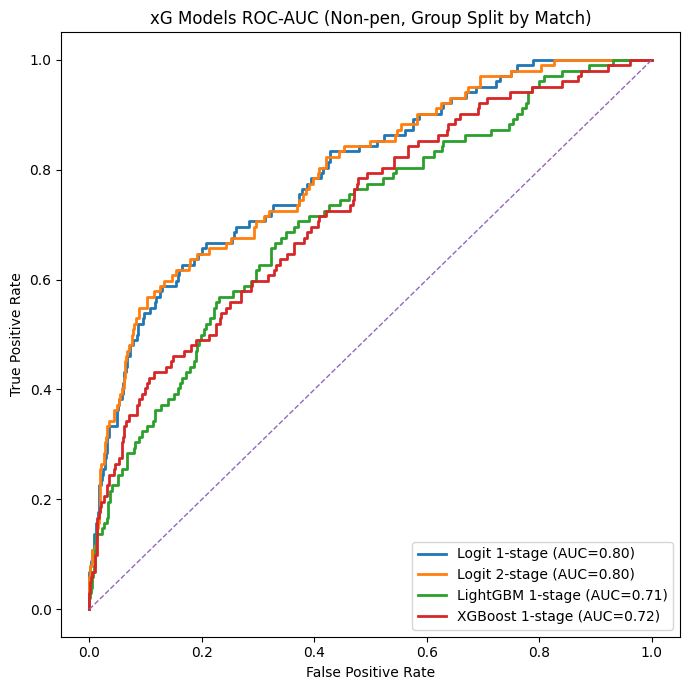

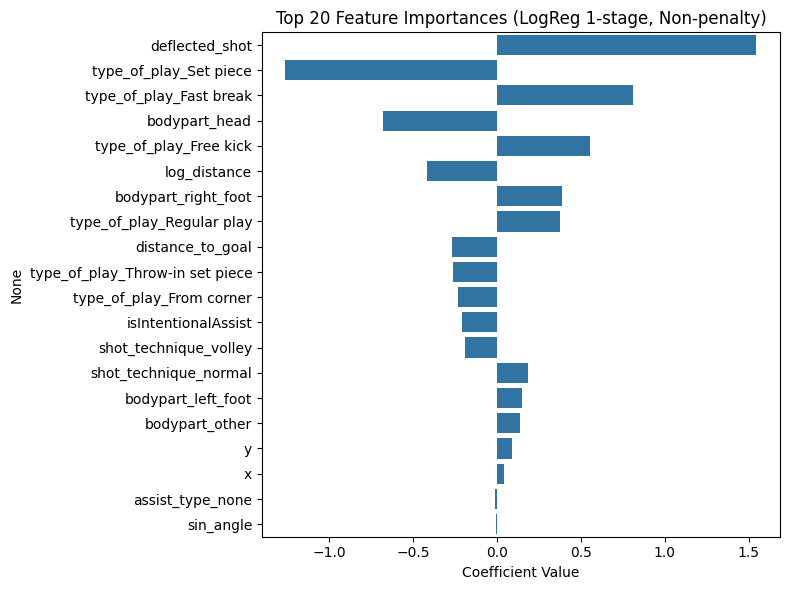

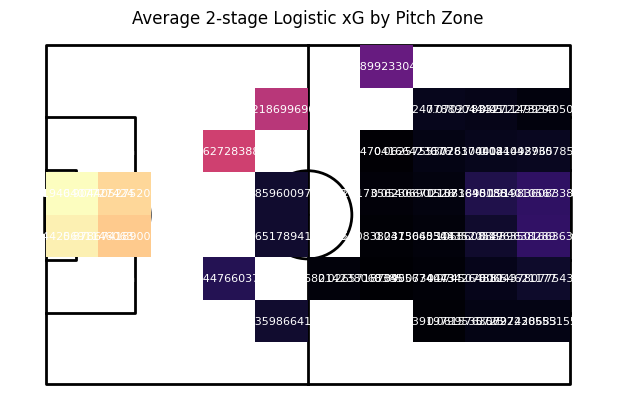

In [1]:
import os
import glob
import json
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import roc_curve, auc
import joblib

import matplotlib.pyplot as plt
from mplsoccer import Pitch
import seaborn as sns

# Optional: Gradient boosting libs
try:
    import lightgbm as lgb
    HAS_LGBM = True
except ImportError:
    HAS_LGBM = False
    print("LightGBM not installed, skipping LightGBM model.")

try:
    import xgboost as xgb
    HAS_XGB = True
except ImportError:
    HAS_XGB = False
    print("XGBoost not installed, skipping XGBoost model.")

# ---------------------------
# Paths
# ---------------------------
folder_path = '/Users/user/XG/Eredivisie 2025-2026/'
json_files = glob.glob(os.path.join(folder_path, '*.json'))

# ---------------------------
# Qualifier constants (from opta-qualifiers.csv)
# ---------------------------
QUAL_ENDX_ID = 140
QUAL_ENDY_ID = 141

QUAL_VOLLEY_ID = 108          # "Volley"
QUAL_OVERHEAD_ID = 109        # "Overhead"
QUAL_HALF_VOLLEY_ID = 110     # "Half Volley"
QUAL_LOB_ID = 117             # "Lob"
QUAL_CHIPPED_ID = 155         # "Chipped"
QUAL_DEFLECTION_ID = 133      # "Deflection"
QUAL_INTENTIONAL_ASSIST_ID = 154  # "Intentional assist"
QUAL_ASSIST_ID = 210              # "Assist"
QUAL_CROSS_ID = 2                 # "Cross"
QUAL_THROUGH_BALL_ID = 4          # "Through ball"
QUAL_PULLBACK_ID = 195            # "Pull Back"

# ---------------------------
# Helper functions
# ---------------------------
def safe_num(value):
    if isinstance(value, (int, float)):
        return value
    try:
        return float(value)
    except (ValueError, TypeError):
        return np.nan

def load_json_events(json_path: str) -> pd.DataFrame:
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)
    events = data.get("event", [])
    rows = []
    for e in events:
        row = {
            "id": e.get("id"),
            "eventId": str(e.get("eventId")),
            "typeId": str(e.get("typeId")),
            "periodId": e.get("periodId"),
            "timeMin": e.get("timeMin"),
            "timeSec": e.get("timeSec"),
            "contestantId": str(e.get("contestantId")),
            "playerId": str(e.get("playerId")),
            "playerName": e.get("playerName"),
            "outcome": int(e.get("outcome") or 0),
            "x": safe_num(e.get("x")),
            "y": safe_num(e.get("y")),
            "timeStamp": e.get("timeStamp"),
            "lastModified": e.get("lastModified"),
        }
        for q in e.get("qualifier", []):
            qid = q.get("qualifierId")
            val = q.get("value", 1)
            row[f"qualifier_{qid}"] = val
        rows.append(row)
    df = pd.DataFrame(rows)

    # End coordinates
    if f"qualifier_{QUAL_ENDX_ID}" in df.columns:
        df["end_x"] = df[f"qualifier_{QUAL_ENDX_ID}"].apply(safe_num)
    else:
        df["end_x"] = np.nan

    if f"qualifier_{QUAL_ENDY_ID}" in df.columns:
        df["end_y"] = df[f"qualifier_{QUAL_ENDY_ID}"].apply(safe_num)
    else:
        df["end_y"] = np.nan

    return df

# ---------------------------
# Load and concatenate all JSONs
# ---------------------------
all_shots_list = []
for json_file_path in json_files:
    df = load_json_events(json_file_path)
    # Shot-related typeIds (13-16)
    df = df[df['typeId'].isin(['13', '14', '15', '16'])].copy().reset_index(drop=True)
    df['match_file'] = os.path.basename(json_file_path)
    all_shots_list.append(df)

new_shots = pd.concat(all_shots_list, ignore_index=True)

# ---------------------------
# Basic shot classification (analysis)
# ---------------------------
is_blocked = (new_shots['typeId'] == '15') & new_shots.get('qualifier_82', pd.Series(dtype=object)).notna()

def define_shot_type(row):
    if is_blocked.loc[row.name]:
        return 'blocked'
    elif row['typeId'] == '15':
        return 'on_target'
    elif row['typeId'] == '13':
        return 'missed'
    elif row['typeId'] == '14':
        return 'post'
    elif row['typeId'] == '16':
        return 'goal'
    else:
        return 'unknown'

new_shots['shot_type'] = new_shots.apply(define_shot_type, axis=1)

def get_bodypart(row):
    if 'qualifier_15' in row and not pd.isna(row['qualifier_15']):
        return 'head'
    elif 'qualifier_72' in row and not pd.isna(row['qualifier_72']):
        return 'left_foot'
    elif 'qualifier_20' in row and not pd.isna(row['qualifier_20']):
        return 'right_foot'
    elif 'qualifier_21' in row and not pd.isna(row['qualifier_21']):
        return 'other'
    else:
        return 'unknown'

new_shots['bodypart'] = new_shots.apply(get_bodypart, axis=1)

play_types = {
    '22': 'Regular play',
    '23': 'Fast break',
    '24': 'Set piece',
    '25': 'From corner',
    '26': 'Free kick',
    '160': 'Throw-in set piece',
    '9': 'penalty'
}

def get_type_of_play(row):
    for qid, q_name in play_types.items():
        col = f'qualifier_{qid}'
        if col in row and not pd.isna(row[col]):
            return q_name
    return 'unknown'

new_shots['type_of_play'] = new_shots.apply(get_type_of_play, axis=1)

# ---------------------------
# Shot technique & assist type (using qualifiers map)
# ---------------------------
def get_shot_technique(row):
    # Order matters: volley / overhead / half-volley / lob / chipped / normal
    if f'qualifier_{QUAL_VOLLEY_ID}' in row and not pd.isna(row[f'qualifier_{QUAL_VOLLEY_ID}']):
        return 'volley'
    if f'qualifier_{QUAL_OVERHEAD_ID}' in row and not pd.isna(row[f'qualifier_{QUAL_OVERHEAD_ID}']):
        return 'overhead'
    if f'qualifier_{QUAL_HALF_VOLLEY_ID}' in row and not pd.isna(row[f'qualifier_{QUAL_HALF_VOLLEY_ID}']):
        return 'half_volley'
    if f'qualifier_{QUAL_LOB_ID}' in row and not pd.isna(row[f'qualifier_{QUAL_LOB_ID}']):
        return 'lob'
    if f'qualifier_{QUAL_CHIPPED_ID}' in row and not pd.isna(row[f'qualifier_{QUAL_CHIPPED_ID}']):
        return 'chipped'
    return 'normal'

new_shots['shot_technique'] = new_shots.apply(get_shot_technique, axis=1)

def get_assist_type(row):
    # Only classify assist if Opta marks it as assist event
    has_assist = f'qualifier_{QUAL_ASSIST_ID}' in row and not pd.isna(row[f'qualifier_{QUAL_ASSIST_ID}'])
    if not has_assist:
        return 'none'
    # Then refine type
    if f'qualifier_{QUAL_CROSS_ID}' in row and not pd.isna(row[f'qualifier_{QUAL_CROSS_ID}']):
        return 'cross'
    if f'qualifier_{QUAL_THROUGH_BALL_ID}' in row and not pd.isna(row[f'qualifier_{QUAL_THROUGH_BALL_ID}']):
        return 'through_ball'
    if f'qualifier_{QUAL_PULLBACK_ID}' in row and not pd.isna(row[f'qualifier_{QUAL_PULLBACK_ID}']):
        return 'pull_back'
    if f'qualifier_{QUAL_CHIPPED_ID}' in row and not pd.isna(row[f'qualifier_{QUAL_CHIPPED_ID}']):
        return 'chipped'
    return 'other'

new_shots['assist_type'] = new_shots.apply(get_assist_type, axis=1)

# Deflected shot flag
deflected_col = f'qualifier_{QUAL_DEFLECTION_ID}'
new_shots['deflected_shot'] = (
    new_shots.get(deflected_col, pd.Series(dtype=object)).notna().astype(int)
)

# ---------------------------
# Geometry features (+ nonlinearities)
# ---------------------------
def calc_distance_angle(x, y, goal_x=100, goal_y=50):
    dx = goal_x - x
    dy = goal_y - y
    distance = np.sqrt(dx**2 + dy**2)
    angle = np.arctan2(dy, dx)
    return distance, np.abs(np.degrees(angle))

new_shots[['distance_to_goal', 'angle_to_goal']] = new_shots.apply(
    lambda row: pd.Series(calc_distance_angle(row['x'], row['y'])),
    axis=1
)

new_shots['distance_sq'] = new_shots['distance_to_goal'] ** 2
new_shots['angle_sq'] = new_shots['angle_to_goal'] ** 2
new_shots['distance_angle_interaction'] = new_shots['distance_to_goal'] * new_shots['angle_to_goal']
new_shots['x_y_interaction'] = new_shots['x'] * new_shots['y']

angle_rad = np.radians(new_shots['angle_to_goal'])
new_shots['cos_angle'] = np.cos(angle_rad)
new_shots['sin_angle'] = np.sin(angle_rad)

new_shots['log_distance'] = np.log(new_shots['distance_to_goal'].clip(lower=0.5))

# ---------------------------
# Fenwick & Corsi (analysis only)
# ---------------------------
fenwick_attempts = new_shots[new_shots['shot_type'] != 'blocked']
fenwick_for = fenwick_attempts.groupby('contestantId').size().reset_index(name='fenwick_for')
total_fenwicks = max(fenwick_attempts.shape[0], 1)
fenwick_for['fenwick_ratio'] = fenwick_for['fenwick_for'] / total_fenwicks

corsi_for = new_shots.groupby('contestantId').size().reset_index(name='corsi_for')
total_corsis = max(new_shots.shape[0], 1)
corsi_for['corsi_ratio'] = corsi_for['corsi_for'] / total_corsis

new_shots = new_shots.merge(fenwick_for[['contestantId', 'fenwick_ratio']], on='contestantId', how='left')
new_shots = new_shots.merge(corsi_for[['contestantId', 'corsi_ratio']], on='contestantId', how='left')

shot_type_weights = {'goal': 1.2, 'on_target': 1.0, 'post': 0.7, 'missed': 0.5, 'blocked': 0.3, 'unknown': 0.1}
new_shots['shot_type_weight'] = new_shots['shot_type'].map(shot_type_weights).fillna(0)

new_shots['inv_distance'] = 1 - (new_shots['distance_to_goal'] / 100)
new_shots['angle_score'] = 1 - (new_shots['angle_to_goal'] / 90)

new_shots['danger_score_fenwick'] = (
    0.3 * new_shots['inv_distance'] +
    0.2 * new_shots['angle_score'] +
    0.3 * new_shots['shot_type_weight'] +
    0.2 * new_shots['fenwick_ratio']
)
new_shots['danger_score_corsi'] = (
    0.4 * new_shots['inv_distance'] +
    0.3 * new_shots['angle_score'] +
    0.2 * new_shots['shot_type_weight'] +
    0.1 * new_shots['corsi_ratio']
)

# ---------------------------
# Targets & flags
# ---------------------------
new_shots['isIntentionalAssist'] = new_shots.get(f'qualifier_{QUAL_INTENTIONAL_ASSIST_ID}', 0).apply(
    lambda x: 1 if x == 1 else 0
)
new_shots['RelatedPlayerId'] = new_shots.get('qualifier_55', np.nan).fillna(-1).astype(int)
new_shots['isGoal'] = (new_shots['typeId'] == '16').astype(int)
new_shots['isBlocked'] = is_blocked
new_shots['isOnTarget'] = new_shots['shot_type'].isin(['on_target', 'goal']).astype(int)

# Penalty vs non-penalty
penalty_mask = new_shots['type_of_play'] == 'penalty'
nonpen_mask = ~penalty_mask

if penalty_mask.sum() > 0:
    penalty_xg = new_shots.loc[penalty_mask, 'isGoal'].mean()
else:
    penalty_xg = 0.76  # fallback

# Initialise xG columns
new_shots['xg_logit_1stage'] = np.nan
new_shots['xg_logit_2stage'] = np.nan
new_shots['xg_lgbm_1stage'] = np.nan
new_shots['xg_xgb_1stage'] = np.nan

# Penalties: constant xG
new_shots.loc[penalty_mask, ['xg_logit_1stage', 'xg_logit_2stage',
                             'xg_lgbm_1stage', 'xg_xgb_1stage']] = penalty_xg

# ---------------------------
# Features for NON-PENALTY shots
# ---------------------------
df_np = new_shots[nonpen_mask].copy()

categorical_features = ['bodypart', 'type_of_play', 'shot_technique', 'assist_type']
numerical_features = [
    'x', 'y',
    'distance_to_goal', 'angle_to_goal',
    'distance_sq', 'angle_sq',
    'distance_angle_interaction', 'x_y_interaction',
    'cos_angle', 'sin_angle',
    'log_distance',
    'isIntentionalAssist',
    'deflected_shot',
]

X_cat_np = pd.get_dummies(df_np[categorical_features], dummy_na=True)
X_num_np = df_np[numerical_features]
X_all_np = pd.concat([X_cat_np, X_num_np], axis=1)

y_goal_np = df_np['isGoal'].astype(int)
y_ontarget_np = df_np['isOnTarget'].astype(int)
groups_np = df_np['match_file']

# ---------------------------
# Group-aware train-test split
# ---------------------------
gss = GroupShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
train_idx_np, test_idx_np = next(gss.split(X_all_np, y_goal_np, groups=groups_np))

X_train_np, X_test_np = X_all_np.iloc[train_idx_np], X_all_np.iloc[test_idx_np]
y_train_goal_np, y_test_goal_np = y_goal_np.iloc[train_idx_np], y_goal_np.iloc[test_idx_np]
y_train_ontarget_np, y_test_ontarget_np = y_ontarget_np.iloc[train_idx_np], y_ontarget_np.iloc[test_idx_np]

# ---------------------------
# 1-STAGE LOGISTIC
# ---------------------------
logreg_1 = LogisticRegression(max_iter=5000, class_weight='balanced')
logit_1stage_model = CalibratedClassifierCV(logreg_1, method='sigmoid', cv=5)
logit_1stage_model.fit(X_train_np, y_train_goal_np)

xg_logit_1_all_np = logit_1stage_model.predict_proba(X_all_np)[:, 1]
new_shots.loc[nonpen_mask, 'xg_logit_1stage'] = xg_logit_1_all_np

y_pred_logit1_test = logit_1stage_model.predict_proba(X_test_np)[:, 1]
fpr_logit1, tpr_logit1, _ = roc_curve(y_test_goal_np, y_pred_logit1_test)
auc_logit1 = auc(fpr_logit1, tpr_logit1)
print(f"Logistic 1-stage xG AUC (non-pen, group-split): {auc_logit1:.3f}")

# ---------------------------
# 2-STAGE LOGISTIC
# ---------------------------
# Stage 1: On-target
logreg_stage1 = LogisticRegression(max_iter=5000, class_weight='balanced')
logit_stage1_model = CalibratedClassifierCV(logreg_stage1, method='sigmoid', cv=5)
logit_stage1_model.fit(X_train_np, y_train_ontarget_np)

p_on_target_all_np = logit_stage1_model.predict_proba(X_all_np)[:, 1]

# Stage 2: Goal | On target (train only on on-target shots in training set)
on_target_train_mask = (y_train_ontarget_np == 1)
X_train_stage2 = X_train_np[on_target_train_mask]
y_train_stage2 = y_train_goal_np[on_target_train_mask]

logreg_stage2 = LogisticRegression(max_iter=5000, class_weight='balanced')
logit_stage2_model = CalibratedClassifierCV(logreg_stage2, method='sigmoid', cv=5)
logit_stage2_model.fit(X_train_stage2, y_train_stage2)

p_goal_given_ot_all_np = logit_stage2_model.predict_proba(X_all_np)[:, 1]

xg_logit_2_all_np = p_on_target_all_np * p_goal_given_ot_all_np
new_shots.loc[nonpen_mask, 'xg_logit_2stage'] = xg_logit_2_all_np

# 2-stage evaluation
p_on_target_test = logit_stage1_model.predict_proba(X_test_np)[:, 1]
p_goal_given_ot_test = logit_stage2_model.predict_proba(X_test_np)[:, 1]
xg_2stage_test = p_on_target_test * p_goal_given_ot_test

fpr_logit2, tpr_logit2, _ = roc_curve(y_test_goal_np, xg_2stage_test)
auc_logit2 = auc(fpr_logit2, tpr_logit2)
print(f"Logistic 2-stage xG AUC (non-pen, group-split): {auc_logit2:.3f}")

# ---------------------------
# LIGHTGBM 1-STAGE
# ---------------------------
if HAS_LGBM:
    lgbm_model = lgb.LGBMClassifier(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=-1,
        subsample=0.9,
        colsample_bytree=0.9,
        objective='binary',
        class_weight='balanced',
        n_jobs=-1,
        random_state=42
    )
    lgbm_model.fit(X_train_np, y_train_goal_np)
    xg_lgbm_all_np = lgbm_model.predict_proba(X_all_np)[:, 1]
    new_shots.loc[nonpen_mask, 'xg_lgbm_1stage'] = xg_lgbm_all_np

    y_pred_lgbm_test = lgbm_model.predict_proba(X_test_np)[:, 1]
    fpr_lgbm, tpr_lgbm, _ = roc_curve(y_test_goal_np, y_pred_lgbm_test)
    auc_lgbm = auc(fpr_lgbm, tpr_lgbm)
    print(f"LightGBM 1-stage xG AUC (non-pen, group-split): {auc_lgbm:.3f}")
else:
    lgbm_model = None

# ---------------------------
# XGBOOST 1-STAGE
# ---------------------------
if HAS_XGB:
    pos = y_train_goal_np.value_counts()
    scale_pos_weight = pos.get(0, 1) / max(pos.get(1, 1), 1)

    xgb_model = xgb.XGBClassifier(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.9,
        colsample_bytree=0.9,
        objective='binary:logistic',
        eval_metric='logloss',
        scale_pos_weight=scale_pos_weight,
        n_jobs=-1,
        random_state=42
    )
    xgb_model.fit(X_train_np, y_train_goal_np)
    xg_xgb_all_np = xgb_model.predict_proba(X_all_np)[:, 1]
    new_shots.loc[nonpen_mask, 'xg_xgb_1stage'] = xg_xgb_all_np

    y_pred_xgb_test = xgb_model.predict_proba(X_test_np)[:, 1]
    fpr_xgb, tpr_xgb, _ = roc_curve(y_test_goal_np, y_pred_xgb_test)
    auc_xgb_val = auc(fpr_xgb, tpr_xgb)
    print(f"XGBoost 1-stage xG AUC (non-pen, group-split): {auc_xgb_val:.3f}")
else:
    xgb_model = None

# ---------------------------
# Scaled indices (0–100), optional
# ---------------------------
for col in ['xg_logit_1stage', 'xg_logit_2stage', 'xg_lgbm_1stage', 'xg_xgb_1stage']:
    if new_shots[col].notna().sum() > 0:
        min_v = new_shots[col].min()
        max_v = new_shots[col].max()
        if max_v > min_v:
            new_shots[col + '_scaled'] = (new_shots[col] - min_v) / (max_v - min_v) * 100
        else:
            new_shots[col + '_scaled'] = 50

# ---------------------------
# Save data & models
# ---------------------------
output_csv = os.path.join(folder_path, 'all_matches_with_xg_qualifiers_enhanced.csv')
new_shots.to_csv(output_csv, index=False)
print(f"Saved combined shot data to {output_csv}")

joblib.dump(logit_1stage_model, os.path.join(folder_path, 'xg_logit_1stage_nonpen.pkl'))
joblib.dump(logit_stage1_model, os.path.join(folder_path, 'xg_logit_stage1_nonpen.pkl'))
joblib.dump(logit_stage2_model, os.path.join(folder_path, 'xg_logit_stage2_nonpen.pkl'))
print("Saved logistic models.")

if lgbm_model is not None:
    joblib.dump(lgbm_model, os.path.join(folder_path, 'xg_lgbm_1stage_nonpen.pkl'))
    print("Saved LightGBM model.")
if xgb_model is not None:
    joblib.dump(xgb_model, os.path.join(folder_path, 'xg_xgb_1stage_nonpen.pkl'))
    print("Saved XGBoost model.")

# ---------------------------
# ROC curves comparison
# ---------------------------
plt.figure(figsize=(7, 7))
plt.plot(fpr_logit1, tpr_logit1, lw=2, label=f'Logit 1-stage (AUC={auc_logit1:.2f})')
plt.plot(fpr_logit2, tpr_logit2, lw=2, label=f'Logit 2-stage (AUC={auc_logit2:.2f})')

if HAS_LGBM:
    plt.plot(fpr_lgbm, tpr_lgbm, lw=2, label=f'LightGBM 1-stage (AUC={auc_lgbm:.2f})')
if HAS_XGB:
    plt.plot(fpr_xgb, tpr_xgb, lw=2, label=f'XGBoost 1-stage (AUC={auc_xgb_val:.2f})')

plt.plot([0, 1], [0, 1], lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('xG Models ROC-AUC (Non-pen, Group Split by Match)')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# ---------------------------
# Feature importance (LogReg 1-stage)
# ---------------------------
logreg_for_coef = LogisticRegression(max_iter=5000, class_weight='balanced')
logreg_for_coef.fit(X_train_np, y_train_goal_np)

coefs = pd.Series(logreg_for_coef.coef_[0], index=X_all_np.columns)
coefs = coefs.sort_values(key=np.abs, ascending=False).head(20)

plt.figure(figsize=(8, 6))
sns.barplot(x=coefs.values, y=coefs.index)
plt.title('Top 20 Feature Importances (LogReg 1-stage, Non-penalty)')
plt.xlabel('Coefficient Value')
plt.tight_layout()
plt.show()

# ---------------------------
# Pitch Heatmap of 2-stage logistic xG
# ---------------------------
pitch = Pitch(pitch_type='opta', pitch_color='white', line_color='black')

bin_stat_xg_2 = pitch.bin_statistic(
    new_shots['x'], new_shots['y'],
    statistic='mean',
    bins=(10, 8),
    values=new_shots['xg_logit_2stage']
)
fig, ax = pitch.draw()
pitch.heatmap(bin_stat_xg_2, ax=ax, cmap='magma')
pitch.label_heatmap(bin_stat_xg_2, ax=ax, color='white', fontsize=8)
plt.title('Average 2-stage Logistic xG by Pitch Zone')
plt.tight_layout()
plt.show()


In [2]:
# ---------------------------
# PLAYER SUMMARY TABLE
# ---------------------------

# Ensure danger columns exist (depending on your pipeline)
danger_cols = [
    "danger_score_fenwick",
    "danger_score_corsi",
    "xg_logit_1stage",
    "xg_logit_2stage",
]

for col in danger_cols:
    if col not in new_shots.columns:
        new_shots[col] = np.nan


# --- Create summary ---
player_summary = (
    new_shots
    .groupby("playerName")
    .agg(
        shots=("id", "count"),
        goals=("isGoal", "sum"),

        # xG + xG difference
        xG=("xg_logit_2stage", "sum"),
        avg_xG=("xg_logit_2stage", "mean"),
        max_xG=("xg_logit_2stage", "max"),
        min_xG=("xg_logit_2stage", "min"),

        # xDanger metrics
        xDanger_fenwick=("danger_score_fenwick", "mean"),
        xDanger_corsi=("danger_score_corsi", "mean"),

        # Shot placement quality
        on_target=("isOnTarget", "sum"),
        blocked=("isBlocked", "sum"),

        # Technique counts
        volleys=("shot_technique", lambda s: (s == "volley").sum()),
        half_volleys=("shot_technique", lambda s: (s == "half_volley").sum()),
        overhead_kicks=("shot_technique", lambda s: (s == "overhead").sum()),
        chipped_shots=("shot_technique", lambda s: (s == "chipped").sum()),
        lobs=("shot_technique", lambda s: (s == "lob").sum()),

        # Assist types
        assist_crosses=("assist_type", lambda s: (s == "cross").sum()),
        assist_through=("assist_type", lambda s: (s == "through_ball").sum()),
        assist_pullbacks=("assist_type", lambda s: (s == "pull_back").sum()),
        assist_other=("assist_type", lambda s: (s == "other").sum()),

        # Distances + angles
        avg_distance=("distance_to_goal", "mean"),
        avg_angle=("angle_to_goal", "mean"),
    )
    .reset_index()
)

# xG Difference (over/underperformance)
player_summary["xG_diff"] = player_summary["goals"] - player_summary["xG"]

# Per-shot efficiency
player_summary["goal_rate"] = player_summary["goals"] / player_summary["shots"]
player_summary["on_target_rate"] = player_summary["on_target"] / player_summary["shots"]
player_summary["blocked_rate"] = player_summary["blocked"] / player_summary["shots"]


# Sort by xG or goals as preferred
player_summary = player_summary.sort_values("xG", ascending=False)


# ---------------------------
# EXPORT TO EXCEL
# ---------------------------
output_file = os.path.join(folder_path, "player_summary.xlsx")
player_summary.to_excel(output_file, index=False)

print(f"Player summary saved to:\n{output_file}")
player_summary.head(20)


Player summary saved to:
/Users/user/XG/Eredivisie 2025-2026/player_summary.xlsx


,playerName,shots,goals,xG,avg_xG,max_xG,min_xG,xDanger_fenwick,xDanger_corsi,on_target,...,assist_crosses,assist_through,assist_pullbacks,assist_other,avg_distance,avg_angle,xG_diff,goal_rate,on_target_rate,blocked_rate
19,A. Ueda,47,13,6.928511,0.147415,0.628682,0.026930,0.636394,0.704664,24,...,0,0,0,0,13.959168,30.454441,6.071489,0.276596,0.510638,0.191489
265,R. van Wolfswinkel,27,6,6.848081,0.253633,0.735294,0.056945,0.628912,0.700802,14,...,0,0,0,0,14.902039,28.699283,-0.848081,0.222222,0.518519,0.296296
108,I. Saibari,44,8,6.383336,0.145076,0.413752,0.020898,0.602298,0.670675,17,...,0,0,0,0,15.996644,33.962790,1.616664,0.181818,0.386364,0.159091
313,T. Parrott,24,6,6.028396,0.251183,0.735294,0.036022,0.643123,0.710807,13,...,0,0,0,0,13.225237,30.213962,-0.028396,0.250000,0.541667,0.166667
69,D. Vente,32,5,5.890588,0.184081,0.735294,0.039592,0.579975,0.662084,10,...,0,0,0,0,15.280621,31.992208,-0.890588,0.156250,0.312500,0.343750
302,T. Chery,37,3,5.651854,0.152753,0.735294,0.023925,0.616747,0.679382,21,...,0,0,0,0,22.903728,27.203223,-2.651854,0.081081,0.567568,0.162162
293,S. Steijn,30,6,5.327884,0.177596,0.735294,0.038461,0.626962,0.715867,12,...,0,0,0,0,15.157813,19.714903,0.672116,0.200000,0.400000,0.366667
95,G. Til,30,8,5.111878,0.170396,0.557523,0.046828,0.608731,0.678249,12,...,0,0,0,0,14.042743,34.298673,2.888122,0.266667,0.400000,0.300000
307,T. Lauritsen,29,6,5.092530,0.175604,0.735294,0.026265,0.623286,0.708101,11,...,0,0,0,0,13.235731,24.933439,0.907470,0.206897,0.379310,0.172414
295,S. van Hooijdonk,27,5,4.937778,0.182881,0.735294,0.039515,0.579263,0.651443,10,...,0,0,0,0,16.161184,36.385148,0.062222,0.185185,0.370370,0.333333


/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_25112/3283085920.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_xg, x="xG", y="playerName", palette="viridis")


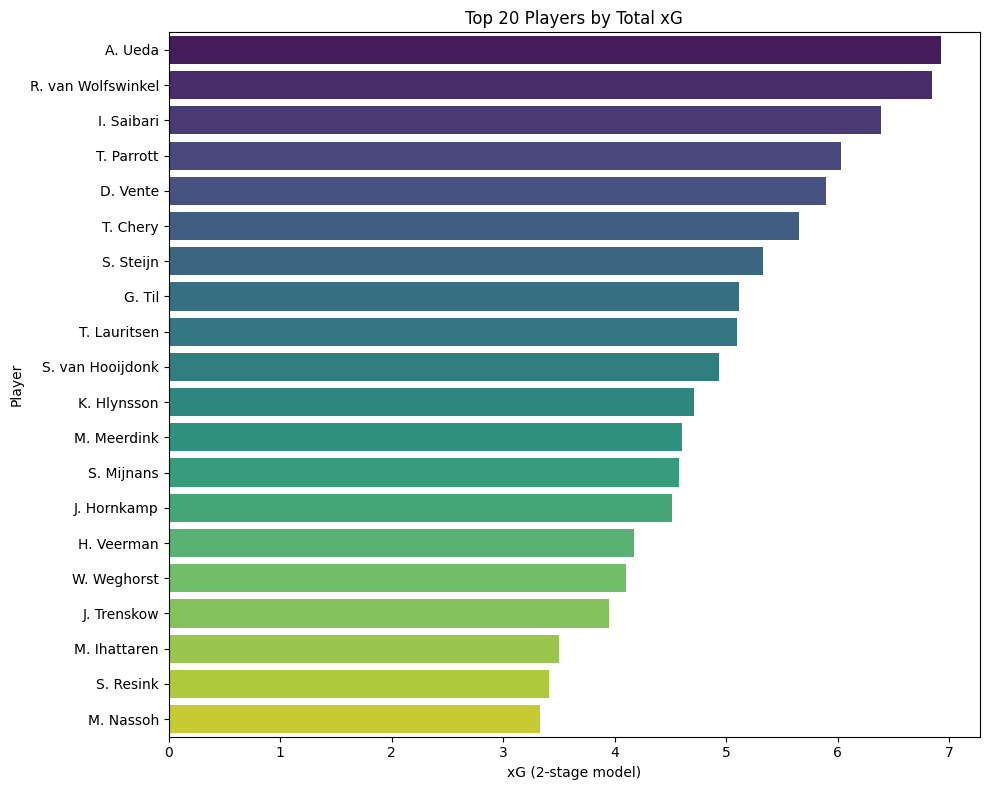

/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_25112/3283085920.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=overperf, x="xG_diff", y="playerName", palette="Blues")


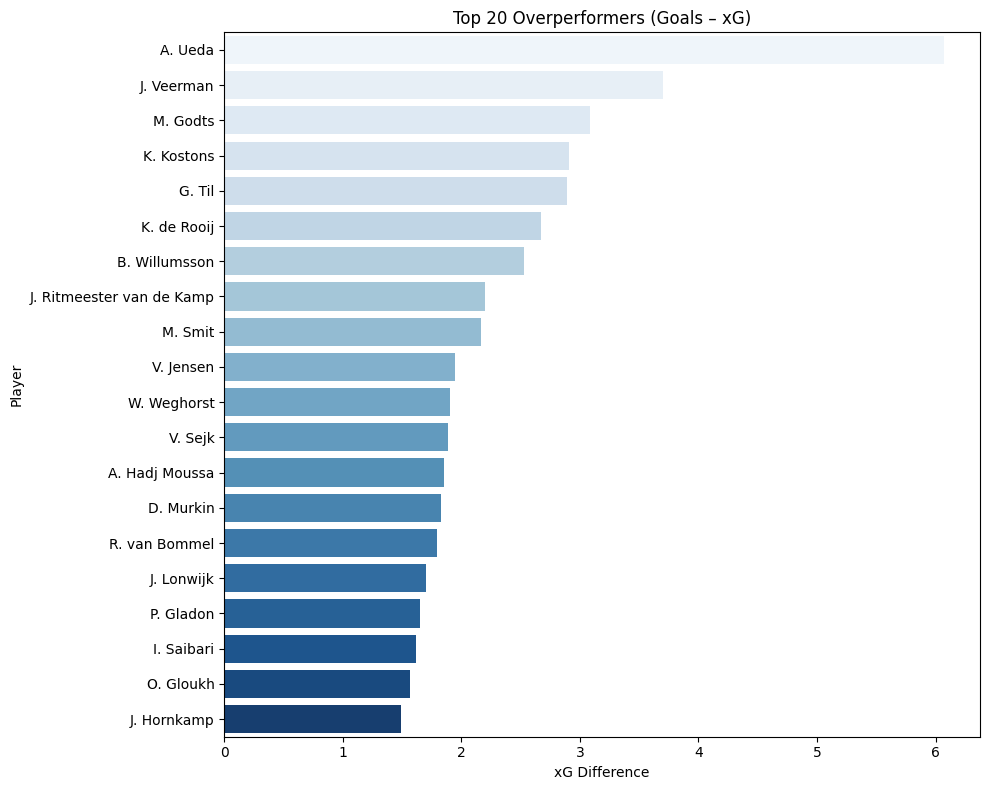

/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_25112/3283085920.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=underperf, x="xG_diff", y="playerName", palette="Reds_r")


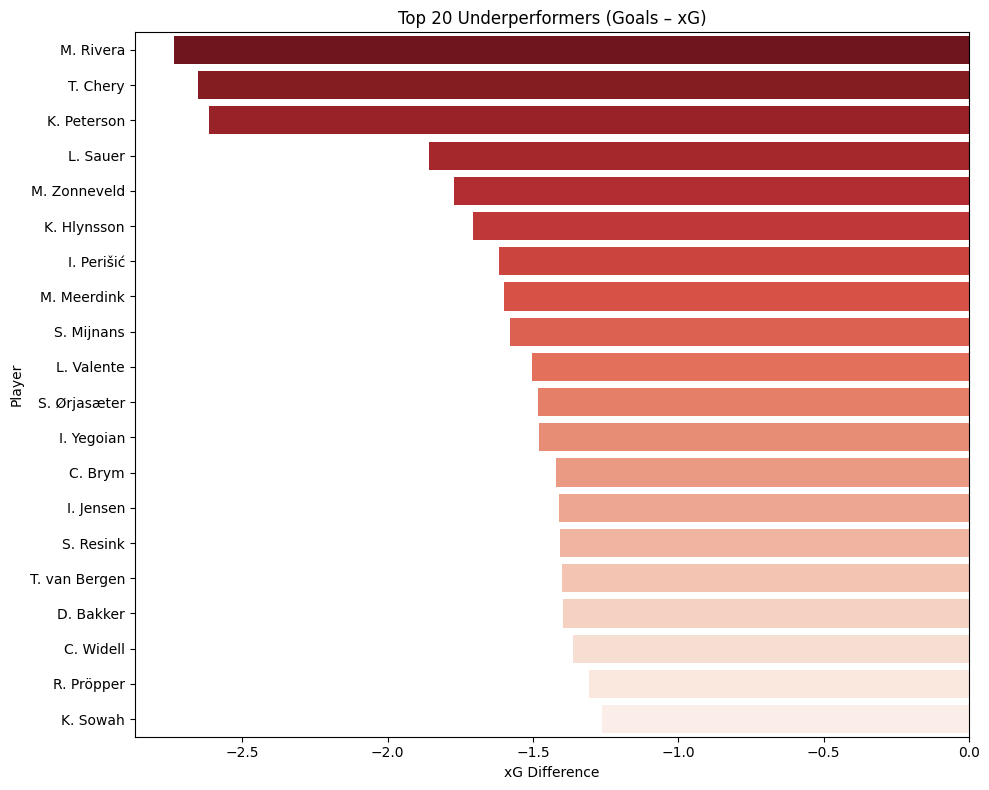

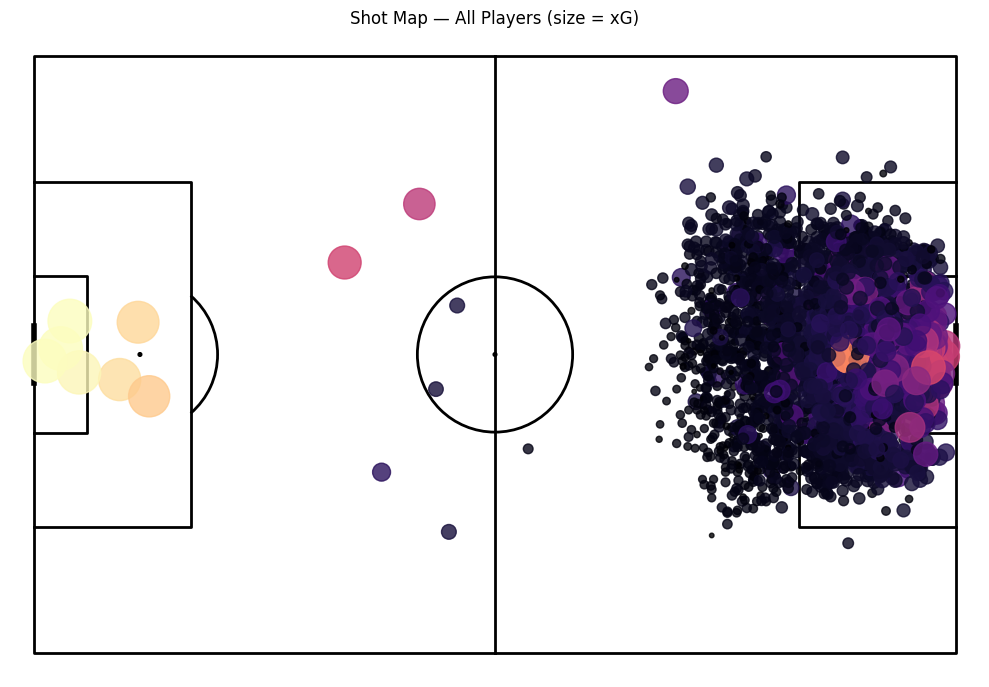

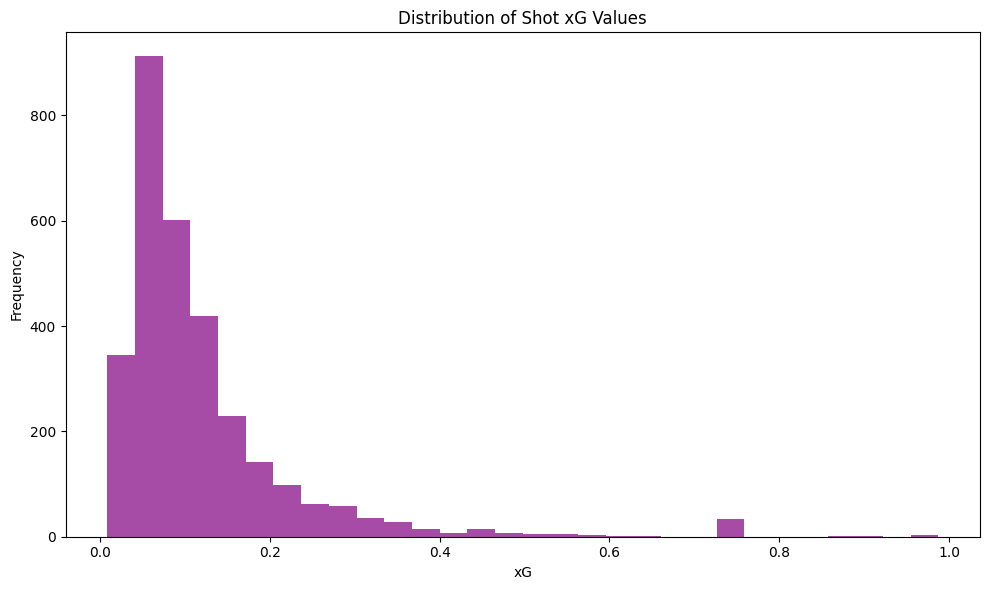

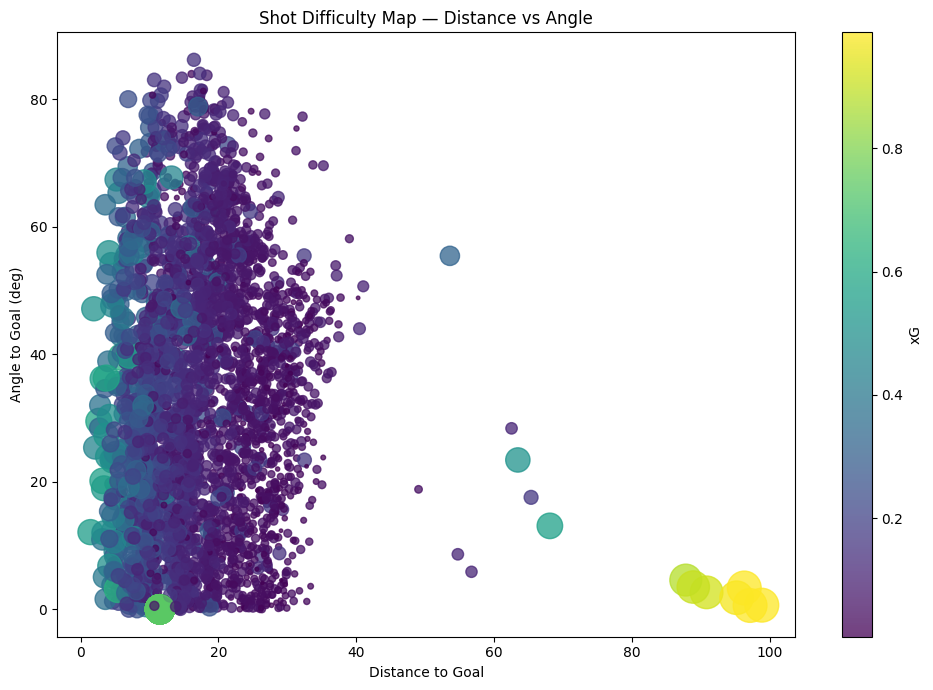

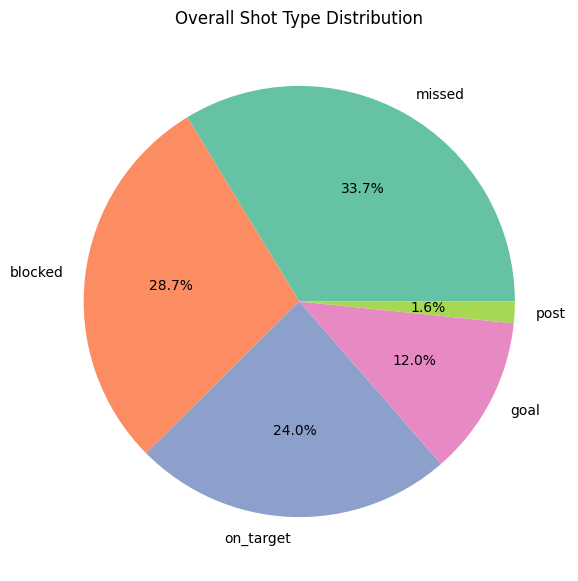

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from mplsoccer import Pitch

# ---------------------------
# 1. Top 20 players by xG
# ---------------------------
top_xg = player_summary.nlargest(20, "xG")

plt.figure(figsize=(10, 8))
sns.barplot(data=top_xg, x="xG", y="playerName", palette="viridis")
plt.title("Top 20 Players by Total xG")
plt.xlabel("xG (2-stage model)")
plt.ylabel("Player")
plt.tight_layout()
plt.show()


# ---------------------------
# 2. Top 20 Overperformers (Goals – xG)
# ---------------------------
overperf = player_summary.nlargest(20, "xG_diff")

plt.figure(figsize=(10, 8))
sns.barplot(data=overperf, x="xG_diff", y="playerName", palette="Blues")
plt.title("Top 20 Overperformers (Goals – xG)")
plt.xlabel("xG Difference")
plt.ylabel("Player")
plt.tight_layout()
plt.show()


# ---------------------------
# 3. Top 20 Underperformers
# ---------------------------
underperf = player_summary.nsmallest(20, "xG_diff")

plt.figure(figsize=(10, 8))
sns.barplot(data=underperf, x="xG_diff", y="playerName", palette="Reds_r")
plt.title("Top 20 Underperformers (Goals – xG)")
plt.xlabel("xG Difference")
plt.ylabel("Player")
plt.tight_layout()
plt.show()


# ---------------------------
# 4. Shot map of all players (scaled by xG)
# ---------------------------
pitch = Pitch(pitch_type="opta", pitch_color="white", line_color="black")
fig, ax = pitch.draw(figsize=(10, 7))

pitch.scatter(
    new_shots["x"],
    new_shots["y"],
    s=new_shots["xg_logit_2stage"] * 1000,
    c=new_shots["xg_logit_2stage"],
    cmap="magma",
    alpha=0.8,
    ax=ax
)

plt.title("Shot Map — All Players (size = xG)")
plt.show()


# ---------------------------
# 5. xG Distribution Histogram
# ---------------------------
plt.figure(figsize=(10, 6))
plt.hist(new_shots["xg_logit_2stage"], bins=30, color="purple", alpha=0.7)
plt.title("Distribution of Shot xG Values")
plt.xlabel("xG")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


# ---------------------------
# 6. Distance vs Angle Scatter (colored by xG)
# ---------------------------
plt.figure(figsize=(10, 7))
plt.scatter(
    new_shots["distance_to_goal"], 
    new_shots["angle_to_goal"], 
    c=new_shots["xg_logit_2stage"], 
    cmap="viridis", 
    s=new_shots["xg_logit_2stage"] * 600,
    alpha=0.75
)
plt.colorbar(label="xG")
plt.xlabel("Distance to Goal")
plt.ylabel("Angle to Goal (deg)")
plt.title("Shot Difficulty Map — Distance vs Angle")
plt.tight_layout()
plt.show()


# ---------------------------
# 7. Player Shot Type Breakdown (pie chart)
# ---------------------------
shot_types = new_shots["shot_type"].value_counts()

plt.figure(figsize=(7, 7))
plt.pie(
    shot_types.values,
    labels=shot_types.index,
    autopct="%1.1f%%",
    colors=sns.color_palette("Set2", len(shot_types))
)
plt.title("Overall Shot Type Distribution")
plt.show()


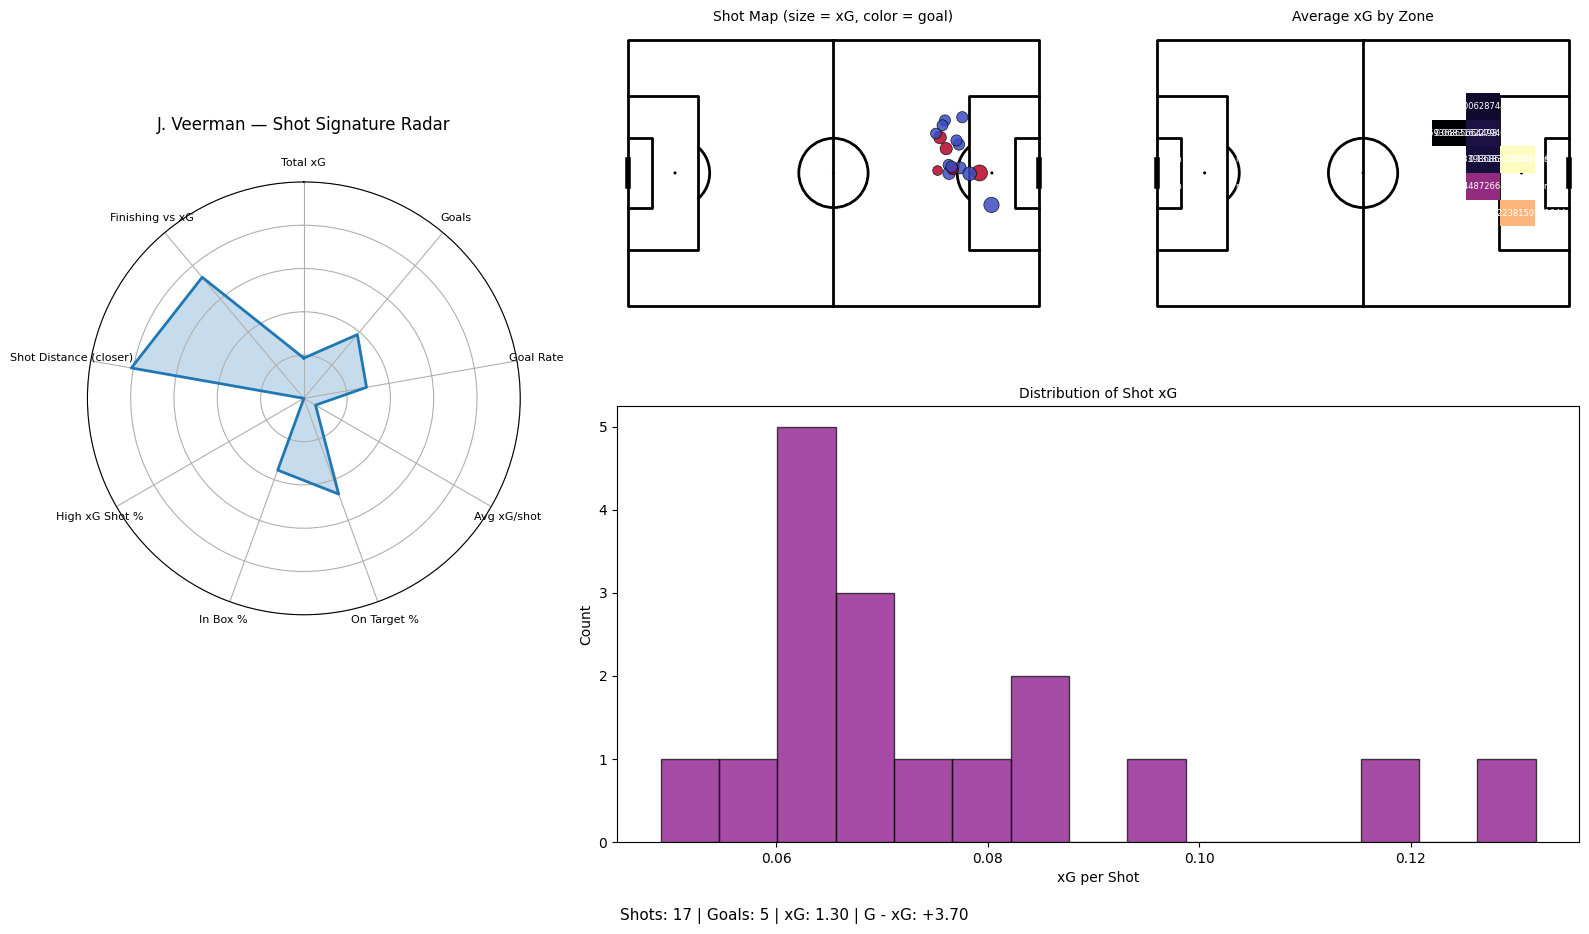

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from math import pi
from mplsoccer import Pitch

# -------------------------------------------------
# Helper: build per-player extra metrics for radar
# -------------------------------------------------
# We use new_shots to compute some extra shares/features
df = new_shots.copy()
df["xG"] = df["xg_logit_2stage"]

# Define "in box" roughly as x > 80 (adjust if needed)
df["in_box"] = (df["x"] >= 80).astype(int)

# Define high xG shot threshold
HIGH_XG_THRESHOLD = 0.15
df["high_xg_shot"] = (df["xG"] >= HIGH_XG_THRESHOLD).astype(int)

radar_features = (
    df
    .groupby("playerName")
    .agg(
        shots=("id", "count"),
        goals=("isGoal", "sum"),
        xG=("xG", "sum"),
        goal_rate=("isGoal", "mean"),
        avg_xG=("xG", "mean"),
        on_target_rate=("isOnTarget", "mean"),
        in_box_share=("in_box", "mean"),
        high_xg_share=("high_xg_shot", "mean"),
        avg_distance=("distance_to_goal", "mean"),
        avg_angle=("angle_to_goal", "mean"),
    )
    .reset_index()
)

# Merge with player_summary to keep consistency (optional)
radar_features = radar_features.merge(
    player_summary[["playerName", "xG_diff"]],
    on="playerName",
    how="left"
)

# -------------------------------------------------
# Normalise metrics for radar (0–1 across all players)
# -------------------------------------------------
# Metrics where "higher is better"
pos_metrics = [
    "xG",
    "goals",
    "goal_rate",
    "avg_xG",
    "on_target_rate",
    "in_box_share",
    "high_xg_share",
]

# Metrics where "lower is better" (we'll invert them)
neg_metrics = [
    "avg_distance",  # closer = better
]

# Safe min-max normalisation
def min_max_norm(series):
    mn = series.min()
    mx = series.max()
    if mx > mn:
        return (series - mn) / (mx - mn)
    else:
        return series * 0 + 0.5  # constant if no variation

radar_norm = radar_features.copy()

for m in pos_metrics:
    radar_norm[m] = min_max_norm(radar_norm[m])

for m in neg_metrics:
    radar_norm[m] = 1 - min_max_norm(radar_norm[m])  # invert so higher = better

# xG_diff can be positive or negative; normalise around 0
radar_norm["xG_diff_norm"] = min_max_norm(radar_features["xG_diff"])

# Choose final metrics for radar
radar_cols = [
    "xG",
    "goals",
    "goal_rate",
    "avg_xG",
    "on_target_rate",
    "in_box_share",
    "high_xg_share",
    "avg_distance",      # already inverted
    "xG_diff_norm",
]

radar_labels = [
    "Total xG",
    "Goals",
    "Goal Rate",
    "Avg xG/shot",
    "On Target %",
    "In Box %",
    "High xG Shot %",
    "Shot Distance (closer)",
    "Finishing vs xG",
]

# -------------------------------------------------
# Main function: full player shot signature report
# -------------------------------------------------
def plot_player_shot_signature(player_name):
    # --- Get radar row ---
    if player_name not in radar_norm["playerName"].values:
        print(f"Player '{player_name}' not found in radar data.")
        return
    
    row = radar_norm[radar_norm["playerName"] == player_name].iloc[0]
    values = [row[c] for c in radar_cols]
    
    # Close the radar loop
    values += values[:1]
    
    N = len(radar_cols)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    
    # --- Create figure with multiple subplots ---
    fig = plt.figure(figsize=(16, 10))
    gs = fig.add_gridspec(2, 3)
    
    # -----------------------
    # 1) Radar chart
    # -----------------------
    ax_radar = fig.add_subplot(gs[:, 0], polar=True)
    ax_radar.set_theta_offset(pi / 2)
    ax_radar.set_theta_direction(-1)
    
    ax_radar.set_xticks(angles[:-1])
    ax_radar.set_xticklabels(radar_labels, fontsize=8)
    
    ax_radar.set_yticklabels([])
    ax_radar.set_ylim(0, 1)
    
    ax_radar.plot(angles, values, linewidth=2, linestyle="solid")
    ax_radar.fill(angles, values, alpha=0.25)
    ax_radar.set_title(f"{player_name} — Shot Signature Radar", fontsize=12, pad=20)
    
    # -----------------------
    # 2) Shot map
    # -----------------------
    df_p = df[df["playerName"] == player_name].copy()
    pitch = Pitch(pitch_type="opta", pitch_color="white", line_color="black")
    ax_map = fig.add_subplot(gs[0, 1])
    pitch.draw(ax=ax_map)
    
    sc = pitch.scatter(
        df_p["x"],
        df_p["y"],
        s=df_p["xG"] * 1000,
        c=df_p["isGoal"],
        cmap="coolwarm",
        edgecolors="black",
        linewidth=0.5,
        alpha=0.85,
        ax=ax_map
    )
    ax_map.set_title("Shot Map (size = xG, color = goal)", fontsize=10)
    
    # -----------------------
    # 3) xG heatmap
    # -----------------------
    ax_heat = fig.add_subplot(gs[0, 2])
    pitch2 = Pitch(pitch_type="opta", pitch_color="white", line_color="black")
    pitch2.draw(ax=ax_heat)
    
    bin_stat = pitch2.bin_statistic(
        df_p["x"], df_p["y"],
        values=df_p["xG"],
        statistic="mean",
        bins=(12, 10)
    )
    
    pitch2.heatmap(bin_stat, ax=ax_heat, cmap="magma")
    pitch2.label_heatmap(bin_stat, ax=ax_heat, color="white", fontsize=6)
    ax_heat.set_title("Average xG by Zone", fontsize=10)
    
    # -----------------------
    # 4) xG histogram
    # -----------------------
    ax_hist = fig.add_subplot(gs[1, 1:])
    ax_hist.hist(df_p["xG"], bins=15, color="purple", alpha=0.7, edgecolor="black")
    ax_hist.set_xlabel("xG per Shot")
    ax_hist.set_ylabel("Count")
    ax_hist.set_title("Distribution of Shot xG", fontsize=10)
    
    # Add some text summary
    total_shots = len(df_p)
    total_goals = df_p["isGoal"].sum()
    total_xg = df_p["xG"].sum()
    xg_diff = total_goals - total_xg
    
    summary_text = (
        f"Shots: {total_shots} | Goals: {total_goals} | xG: {total_xg:.2f} | "
        f"G - xG: {xg_diff:+.2f}"
    )
    fig.text(0.5, 0.02, summary_text, ha="center", fontsize=11)
    
    plt.tight_layout(rect=[0, 0.04, 1, 1])
    plt.show()

# -------------------------------------------------
# Example usage:
# -------------------------------------------------
# Replace with any player in your data
plot_player_shot_signature("J. Veerman")


Saved: /Users/user/Downloads/xDanger/xG_Pitch.png


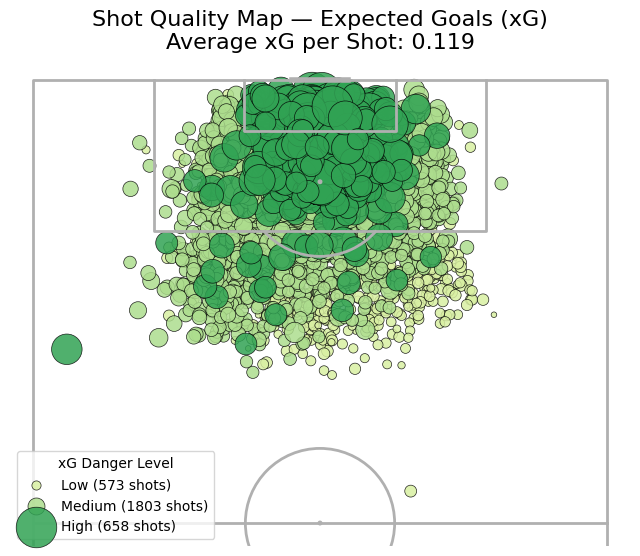

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from mplsoccer.pitch import VerticalPitch
import numpy as np

# --- Load your enhanced dataset (with xG columns) ---
file_path = "/Users/user/XG/Eredivisie 2025-2026/all_matches_with_xg_qualifiers_enhanced.csv"
df = pd.read_csv(file_path)

# Use your 2-stage xG model
df["xG"] = df["xg_logit_2stage"]

# --- Compute average xG ---
avg_xg = df['xG'].mean()

# --- Define xG bins (adjust to your ranges) ---
bins = [0, 0.05, 0.15, 1.0]  # Low <5%, Medium <15%, High >15% 
labels = ['Low', 'Medium', 'High']

df['xg_bin'] = pd.cut(df['xG'], bins=bins, labels=labels, include_lowest=True)

# --- Define colors ---
color_map_xg = {
    'Low': '#d9f0a3',      # light green
    'Medium': '#addd8e',   # medium green
    'High': '#31a354'      # dark green
}

# --- Create figure ---
fig, ax = plt.subplots(figsize=(8, 12))

# Create vertical half pitch
pitch = VerticalPitch(
    half=True,
    pitch_type='opta',
    line_zorder=2,
    pitch_color='white'
)
pitch.draw(ax=ax)

# --- Plot xG on one pitch ---
for bin_label, color in color_map_xg.items():
    subset = df[df["xg_bin"] == bin_label]
    pitch.scatter(
        subset["x"], subset["y"],
        s=subset["xG"] * 1500,     # size scales with xG
        c=color,
        edgecolors='black',
        linewidth=0.5,
        alpha=0.85,
        ax=ax,
        label=f"{bin_label} ({len(subset)} shots)"
    )

# Legend
ax.legend(title="xG Danger Level", loc='lower left')

# Title
ax.set_title(
    f"Shot Quality Map — Expected Goals (xG)\nAverage xG per Shot: {avg_xg:.3f}",
    fontsize=16
)

# Save
out_path = "/Users/user/Downloads/xDanger/xG_Pitch.png"
plt.savefig(out_path, dpi=300, bbox_inches='tight')
print("Saved:", out_path)

plt.show()


<Figure size 800x600 with 0 Axes>

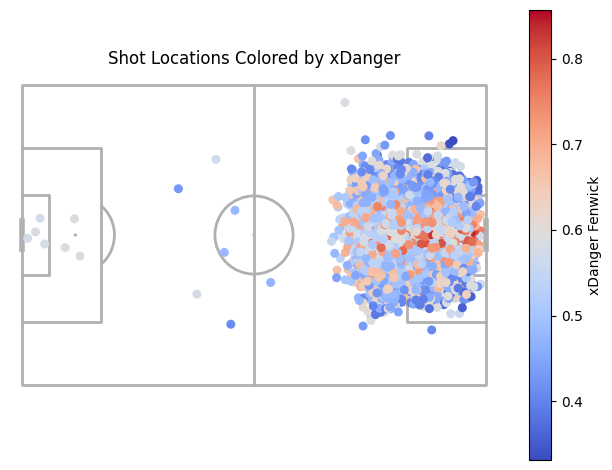

In [6]:
plt.figure(figsize=(8,6))
pitch = Pitch(pitch_type='opta')
fig, ax = pitch.draw()

sc = ax.scatter(df.x, df.y, c=df['danger_score_fenwick'], cmap='coolwarm', s=30)
plt.colorbar(sc).set_label("xDanger Fenwick")
plt.title("Shot Locations Colored by xDanger")
plt.show()


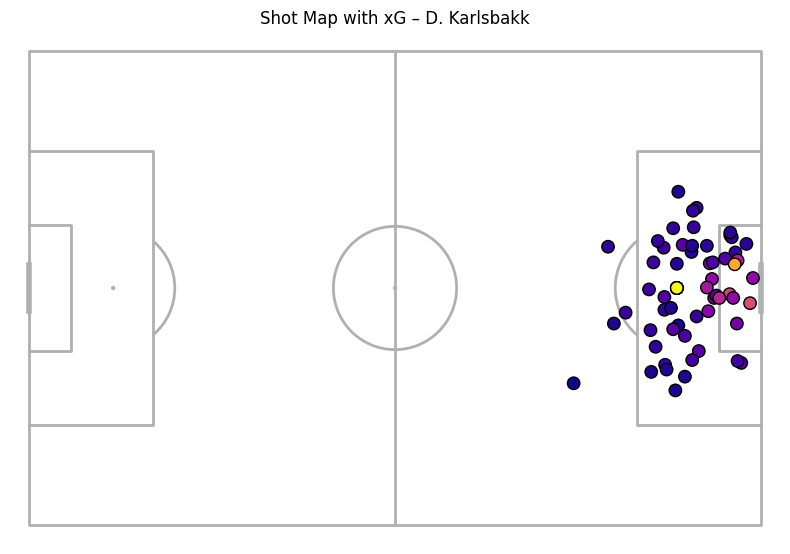

In [19]:
player = "D. Karlsbakk"
sub = df[df['playerName'] == player]

pitch = Pitch( pitch_type='opta')
fig, ax = pitch.draw(figsize=(8, 6))

ax.scatter(sub.x, sub.y, c=sub['xg_logit_2stage'], cmap='plasma', s=80, edgecolor='black')
plt.title(f"Shot Map with xG – {player}")
plt.show()


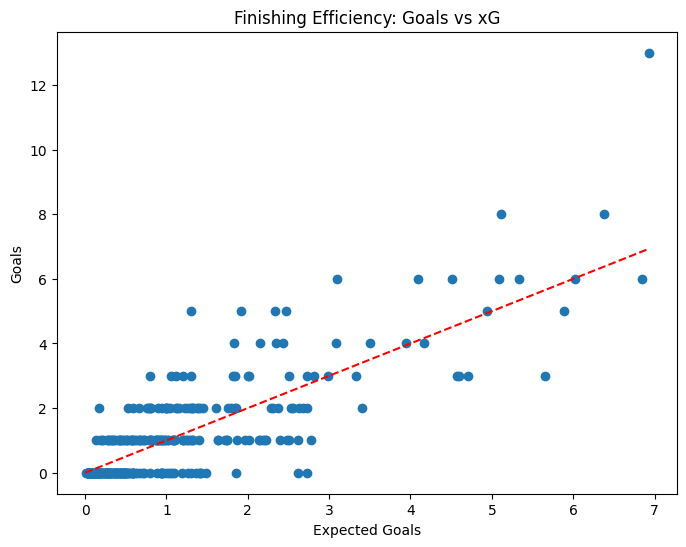

In [7]:
group = df.groupby("playerName").agg(goals=("isGoal","sum"), xG=("xg_logit_2stage","sum"))

plt.figure(figsize=(8,6))
plt.scatter(group.xG, group.goals)
plt.plot([0, group.xG.max()], [0, group.xG.max()], 'r--')
plt.xlabel("Expected Goals")
plt.ylabel("Goals")
plt.title("Finishing Efficiency: Goals vs xG")
plt.show()


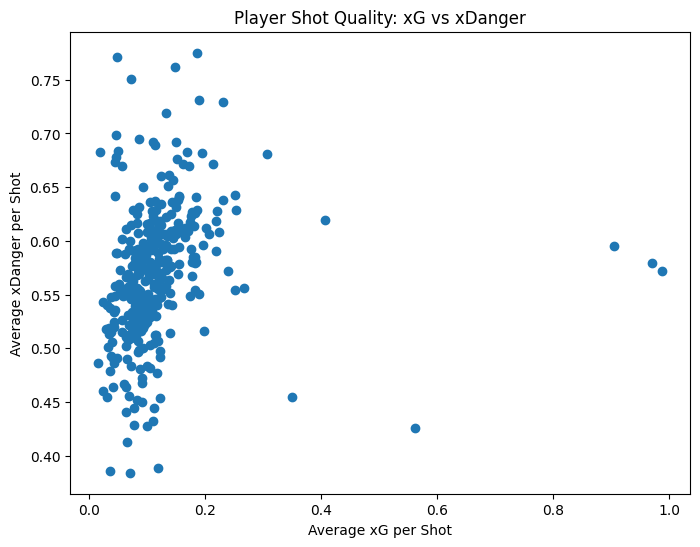

In [8]:
group = df.groupby("playerName").agg(
    avg_xG=("xg_logit_2stage","mean"),
    avg_xDanger=("danger_score_fenwick","mean")
)

plt.figure(figsize=(8,6))
plt.scatter(group.avg_xG, group.avg_xDanger)
plt.xlabel("Average xG per Shot")
plt.ylabel("Average xDanger per Shot")
plt.title("Player Shot Quality: xG vs xDanger")
plt.show()


In [31]:
import pandas as pd
import glob
import os

folder_path = "/Users/user/XG/Iceland/xgCSV/"   # <-- change this

# Load all CSV files in the folder
csv_files = glob.glob(os.path.join(folder_path, "*.csv"))

dfs = []
for file in csv_files:
    df = pd.read_csv(file)
    dfs.append(df)

# Concatenate all data
all_data = pd.concat(dfs, ignore_index=True)

# Calculate average of the xG column
xg_average = all_data["xG"].mean()

print("Average xG:", xg_average)


Average xG: 0.12892559071707033


/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_83006/2337884604.py:5: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/Users/user/XG/Iceland/DONE/all_matches_with_xg_qualifiers_enhanced.csv")


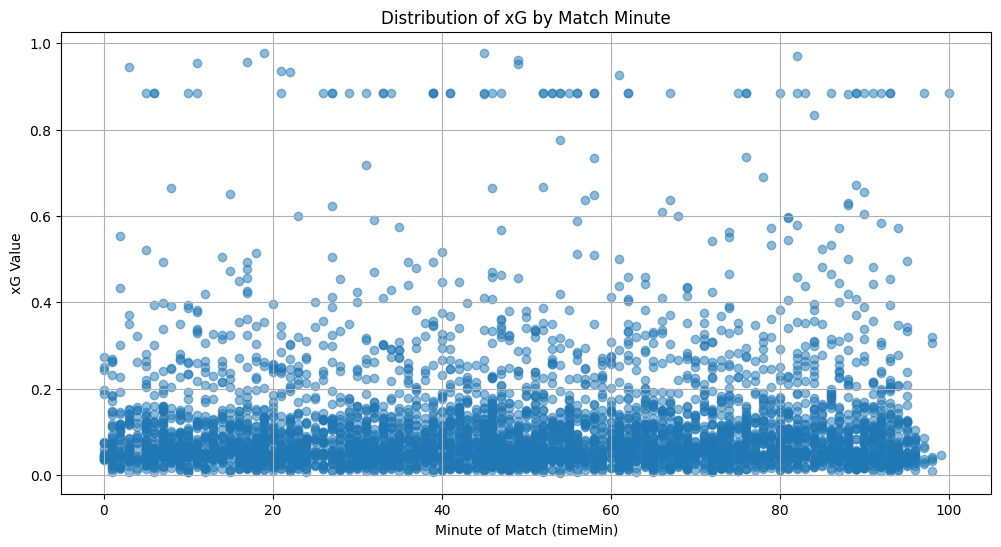

In [40]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv("/Users/user/XG/Iceland/DONE/all_matches_with_xg_qualifiers_enhanced.csv")
df["xG"] = df["xg_logit_2stage"]

# Basic scatter plot
plt.figure(figsize=(12, 6))
plt.scatter(df["timeMin"], df["xG"], alpha=0.5)

# Labels and title
plt.xlabel("Minute of Match (timeMin)")
plt.ylabel("xG Value")
plt.title("Distribution of xG by Match Minute")
plt.grid(True)

# Show the plot
plt.show()


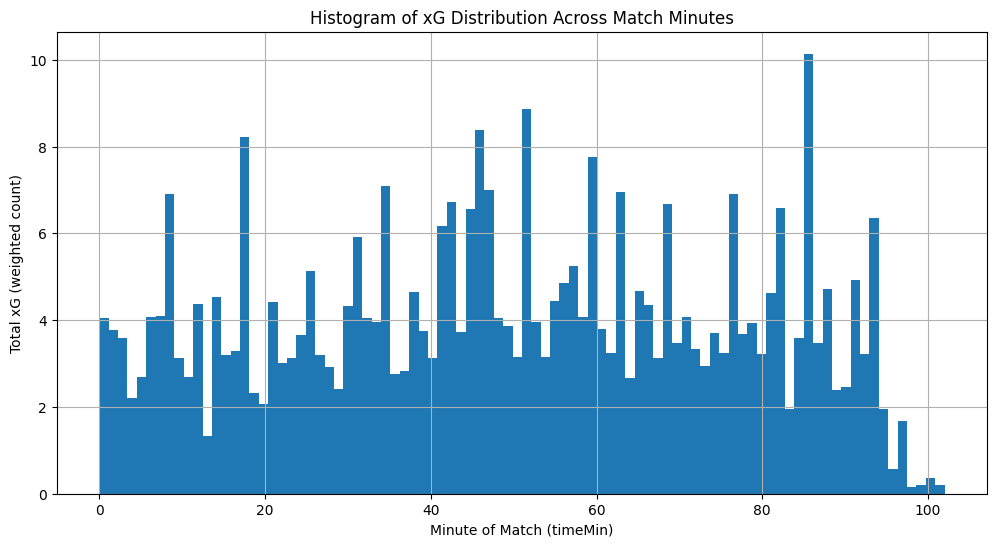

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv("/Users/user/XG/Eredivisie 2025-2026/all_matches_with_xg_qualifiers_enhanced.csv")
df["xG"] = df["xg_logit_2stage"]

plt.figure(figsize=(12, 6))
plt.hist(df["timeMin"], bins=90, weights=df["xG"])

plt.xlabel("Minute of Match (timeMin)")
plt.ylabel("Total xG (weighted count)")
plt.title("Histogram of xG Distribution Across Match Minutes")
plt.grid(True)
plt.show()


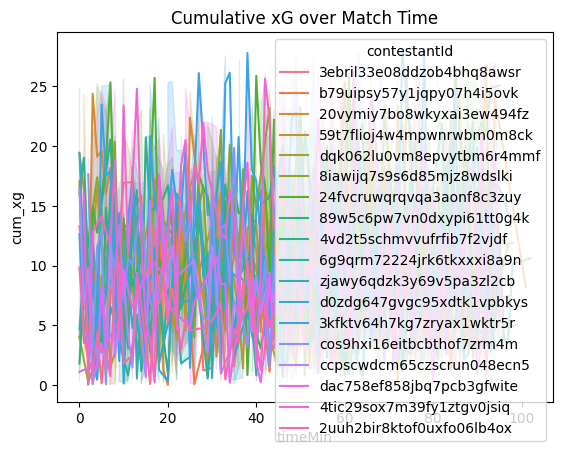

In [10]:
df = new_shots.sort_values(['match_file', 'periodId', 'timeMin', 'timeSec'])

df['cum_xg'] = df.groupby('contestantId')['xg_logit_2stage'].cumsum()

sns.lineplot(data=df, x='timeMin', y='cum_xg', hue='contestantId')
plt.title("Cumulative xG over Match Time")
plt.show()


<Axes: title={'center': 'Average xG by Shot Technique'}, xlabel='shot_technique'>

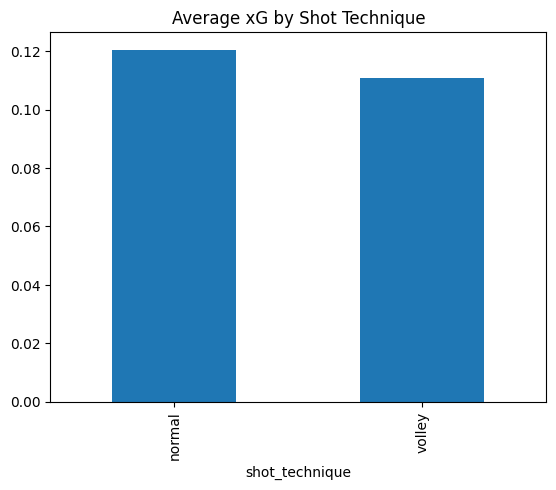

In [11]:
tech_stats = new_shots.groupby('shot_technique')['xg_logit_2stage'].mean()
tech_stats.plot(kind='bar', title="Average xG by Shot Technique")


[INFO] Loaded 181340 total events from JSON.
[INFO] Assigned possessions; max possession_id: 881
[INFO] Loaded 3034 shot rows with xG from /Users/user/XG/Eredivisie 2025-2026/all_matches_with_xg_qualifiers_enhanced.csv
[INFO] Merged shot xG into events.
/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_25112/1584432020.py:242: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ).apply(_future_xg).reset_index(level=[0, 1], drop=True)
[INFO] Computed future_xg_in_possession and possession_xg_sum.
[INFO] Build-up feature matrix shape: (181340, 68)
[INFO] Training LightGBM Regressor for build-up value...


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002797 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1771
[LightGBM] [Info] Number of data points in the train set: 126552, number of used features: 58
[LightGBM] [Info] Start training from score 0.006371


[INFO] Build-up model: RMSE=0.0323, MAE=0.0091, R2=0.273
[INFO] Saved event-level build-up data to /Users/user/XG/Eredivisie 2025-2026/all_events_with_xg_buildup.csv


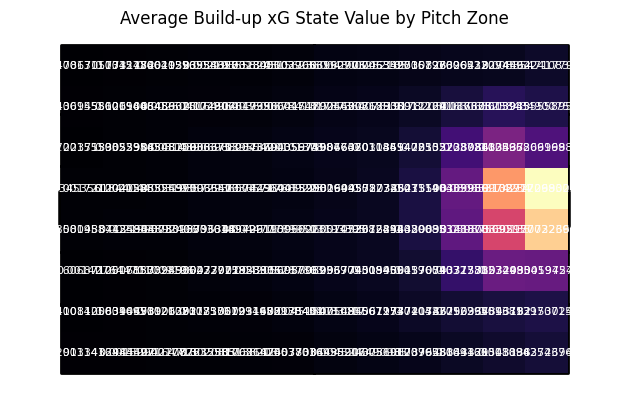

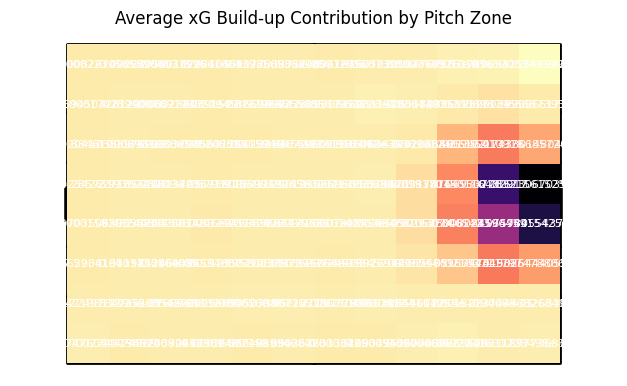

[INFO] Top build-up players (by xg_buildup_contrib):
[INFO] 
           playerName  total_xg_buildup_contrib
0          E. Vaessen                  0.329194
1        Mauro Júnior                  0.293071
2          T. Ouwejan                  0.261652
3           J. Clasie                  0.177686
4      S. El Karouani                  0.169003
5             E. Poku                  0.152898
6         J. Dahlhaus                  0.143426
7           Ivo Pinto                  0.131182
8            W. Prins                  0.116789
9            T. Holla                  0.115092
10          R. Koeman                  0.107700
11  J. Reine-Adélaïde                  0.101823
12          J. Tijink                  0.100380
13            W. Goes                  0.099406
14    J. van den Berg                  0.089442
[INFO] Top build-up teams (by xg_buildup_contrib):
[INFO] 
                contestantId  total_xg_buildup_contrib
0  2uuh2bir8ktof0uxfo06lb4ox                -12.331799
1 

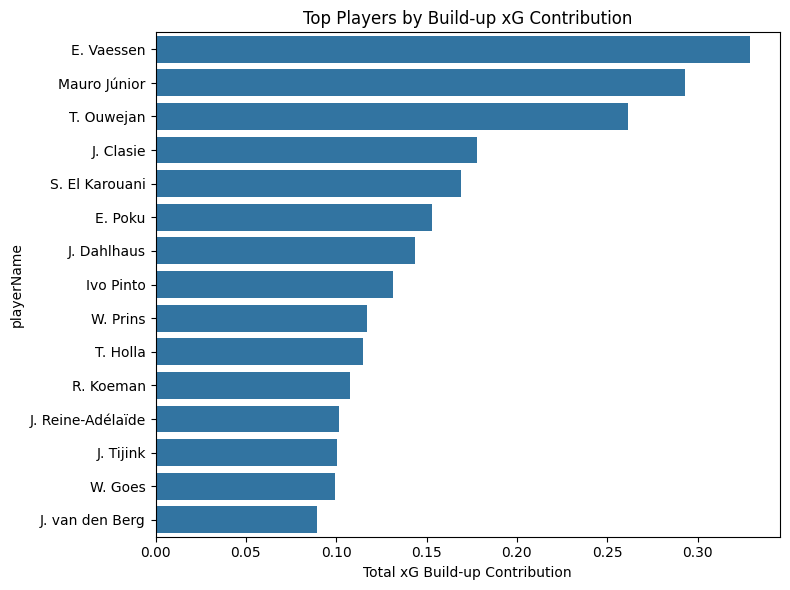

In [13]:
import os
import glob
import json
import logging

from typing import Tuple, Dict, Any

import numpy as np
import pandas as pd

from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
from mplsoccer import Pitch
import seaborn as sns

# Optional LightGBM for regression
try:
    import lightgbm as lgb
    HAS_LGBM = True
except ImportError:
    HAS_LGBM = False
    print("LightGBM not installed, will use RandomForestRegressor instead.")

# =============================================================================
# CONFIG
# =============================================================================
RANDOM_STATE = 42

FOLDER_PATH = "/Users/user/XG/Eredivisie 2025-2026/"
JSON_GLOB = "*.json"

# Input: shot-level xG file created by your earlier xG script
SHOT_XG_CSV = os.path.join(FOLDER_PATH, "all_matches_with_xg_qualifiers_enhanced.csv")

# Output: event-level build-up file
OUTPUT_BUILDUP_CSV = os.path.join(FOLDER_PATH, "all_events_with_xg_buildup.csv")

# Logging
logging.basicConfig(
    level=logging.INFO,
    format='[%(levelname)s] %(message)s'
)
logger = logging.getLogger(__name__)

# Qualifier constants for end coordinates
QUAL_ENDX_ID = 140
QUAL_ENDY_ID = 141


# =============================================================================
# UTILITIES
# =============================================================================
def safe_num(value):
    if isinstance(value, (int, float)):
        return float(value)
    try:
        return float(value)
    except (ValueError, TypeError):
        return np.nan


def load_json_events(json_path: str) -> pd.DataFrame:
    """
    Load a single JSON file of Opta events and convert to a dataframe.
    This loads ALL events (not only shots).
    """
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    events = data.get("event", [])
    rows = []
    for e in events:
        row = {
            "id": e.get("id"),
            "eventId": str(e.get("eventId")),
            "typeId": str(e.get("typeId")),
            "periodId": e.get("periodId"),
            "timeMin": safe_num(e.get("timeMin")),
            "timeSec": safe_num(e.get("timeSec")),
            "contestantId": str(e.get("contestantId")),
            "playerId": str(e.get("playerId")) if e.get("playerId") is not None else None,
            "playerName": e.get("playerName"),
            "outcome": int(e.get("outcome") or 0),
            "x": safe_num(e.get("x")),
            "y": safe_num(e.get("y")),
            "timeStamp": e.get("timeStamp"),
            "lastModified": e.get("lastModified"),
        }
        for q in e.get("qualifier", []):
            qid = q.get("qualifierId")
            val = q.get("value", 1)
            row[f"qualifier_{qid}"] = val
        rows.append(row)

    df = pd.DataFrame(rows)

    # End coordinates
    for qid, col_name in [(QUAL_ENDX_ID, "end_x"), (QUAL_ENDY_ID, "end_y")]:
        col = f"qualifier_{qid}"
        if col in df.columns:
            df[col_name] = df[col].apply(safe_num)
        else:
            df[col_name] = np.nan

    return df


def add_match_and_time(df: pd.DataFrame, match_file: str) -> pd.DataFrame:
    """Add match file name and event time (in seconds) per match/period."""
    df = df.copy()
    df["match_file"] = os.path.basename(match_file)

    # handle NaN times gracefully
    df["timeMin"] = df["timeMin"].fillna(0)
    df["timeSec"] = df["timeSec"].fillna(0)

    # basic event time within period (no total-match adjustment needed for possessions)
    df["event_seconds"] = df["timeMin"] * 60 + df["timeSec"]
    return df


# =============================================================================
# POSSESSIONS
# =============================================================================
def assign_possessions(events: pd.DataFrame, time_gap: float = 10.0) -> pd.DataFrame:
    """
    Assign possession IDs based on:
        - same team in control
        - small time gap between events
    This is a basic heuristic; you can refine with more event-type logic later.
    """
    df = events.sort_values(
        ["match_file", "periodId", "event_seconds", "id"]
    ).reset_index(drop=True)

    # Team change
    df["team_change"] = (
        (df["contestantId"] != df["contestantId"].shift(1)) |
        (df["match_file"] != df["match_file"].shift(1)) |
        (df["periodId"] != df["periodId"].shift(1))
    ).astype(int)

    # Time gap
    df["time_diff"] = df.groupby(["match_file", "periodId"])["event_seconds"].diff().fillna(0)
    df["big_gap"] = (df["time_diff"] > time_gap).astype(int)

    # Possession change if team changes or big time gap
    df["possession_change"] = ((df["team_change"] == 1) | (df["big_gap"] == 1)).astype(int)

    # Cumulate to assign unique possession ids within each match
    df["possession_id"] = df.groupby("match_file")["possession_change"].cumsum()

    # Some convenience metrics within possessions
    df["event_index_in_possession"] = df.groupby(
        ["match_file", "possession_id"]
    ).cumcount()

    df["possession_start_time"] = df.groupby(
        ["match_file", "possession_id"]
    )["event_seconds"].transform("min")

    df["time_since_possession_start"] = df["event_seconds"] - df["possession_start_time"]

    return df


# =============================================================================
# MERGE SHOT XG INTO EVENTS
# =============================================================================
def merge_shot_xg(events: pd.DataFrame, shot_xg_csv: str) -> pd.DataFrame:
    """
    Merge shot-level xG outputs (from your xG script) onto full events.
    Assumes:
        - shot CSV contains 'id' and 'match_file'
        - xG column to use: 'xg_logit_2stage'
    """
    if not os.path.exists(shot_xg_csv):
        raise FileNotFoundError(
            f"Shot xG CSV not found at {shot_xg_csv}. "
            f"Run your xG model script first."
        )

    shots = pd.read_csv(shot_xg_csv)

    # Ensure match_file & id exist in both
    if "match_file" not in shots.columns:
        raise ValueError("Shot CSV must contain 'match_file' column.")

    logger.info(f"Loaded {shots.shape[0]} shot rows with xG from {shot_xg_csv}")

    # We'll treat shot events as those rows in the CSV
    shots_sub = shots[["id", "match_file", "xg_logit_2stage", "isGoal"]].copy()

    # Merge
    merged = events.merge(
        shots_sub,
        on=["id", "match_file"],
        how="left",
        suffixes=("", "_shot")
    )

    # shot_xg is NaN for non-shot events
    merged["shot_xg"] = merged["xg_logit_2stage"]
    merged["isShot"] = merged["shot_xg"].notna().astype(int)
    merged["isGoal"] = merged["isGoal"].fillna(0).astype(int)

    return merged


# =============================================================================
# FUTURE XG (LABEL FOR BUILD-UP)
# =============================================================================
def compute_future_xg(events: pd.DataFrame) -> pd.DataFrame:
    """
    For each event, compute:
        - possession_xg_sum: total xG of shots in that possession
        - future_xg_in_possession: total xG of shots from this event onward
    """
    df = events.sort_values(
        ["match_file", "possession_id", "event_seconds", "id"]
    ).reset_index(drop=True)

    # total xG per possession
    poss_xg = df.groupby(
        ["match_file", "possession_id"]
    )["shot_xg"].sum().fillna(0)

    df["possession_xg_sum"] = df.set_index(
        ["match_file", "possession_id"]
    ).index.map(poss_xg)

    # future_xg within possession: reverse cumulative sum of shot_xg
    def _future_xg(group: pd.DataFrame) -> pd.Series:
        x = group["shot_xg"].fillna(0).values[::-1].cumsum()[::-1]
        return pd.Series(x, index=group.index)

    df["future_xg_in_possession"] = df.groupby(
        ["match_file", "possession_id"]
    ).apply(_future_xg).reset_index(level=[0, 1], drop=True)

    # We can also add "xg_before_event" if needed (total xG of previous shots in possession)
    df["xg_before_event"] = df["possession_xg_sum"] - df["future_xg_in_possession"]

    return df


# =============================================================================
# BUILD-UP MODEL TRAINING
# =============================================================================
def build_feature_matrix(events: pd.DataFrame) -> Tuple[pd.DataFrame, pd.Series, pd.Series]:
    """
    Build features X, target y, groups for build-up value model.
    Target = future_xg_in_possession (regression).
    """
    df = events.copy()

    # Filter out rows with missing key location/time data if necessary
    df = df[~df["x"].isna() & ~df["y"].isna()].copy()

    # Basic numeric features
    df["end_x"] = df["end_x"].fillna(df["x"])
    df["end_y"] = df["end_y"].fillna(df["y"])
    df["pass_length"] = np.sqrt((df["end_x"] - df["x"]) ** 2 + (df["end_y"] - df["y"]) ** 2)
    df["pass_angle"] = np.degrees(np.arctan2(df["end_y"] - df["y"], df["end_x"] - df["x"]))

    # time since previous event within possession
    df["time_diff_in_poss"] = df.groupby(
        ["match_file", "possession_id"]
    )["event_seconds"].diff().fillna(0)

    # target
    y = df["future_xg_in_possession"].fillna(0)

    # categorical features (we can treat typeId as categorical)
    cat_cols = ["typeId", "periodId"]
    num_cols = [
        "x", "y", "end_x", "end_y",
        "pass_length", "pass_angle",
        "time_diff_in_poss",
        "time_since_possession_start",
        "event_index_in_possession"
    ]

    # one-hot encode categoricals
    X_cat = pd.get_dummies(df[cat_cols].astype(str), dummy_na=True)
    X_num = df[num_cols]
    X = pd.concat([X_cat, X_num], axis=1)

    groups = df["match_file"]

    logger.info(f"Build-up feature matrix shape: {X.shape}")
    return X, y, groups


def train_buildup_model(X: pd.DataFrame, y: pd.Series, groups: pd.Series) -> Tuple[Any, Dict[str, float]]:
    """
    Train a regression model to predict future_xg_in_possession.
    Use GroupShuffleSplit to respect match-level grouping.
    """
    gss = GroupShuffleSplit(n_splits=1, test_size=0.3, random_state=RANDOM_STATE)
    train_idx, test_idx = next(gss.split(X, y, groups))

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    if HAS_LGBM:
        logger.info("Training LightGBM Regressor for build-up value...")
        model = lgb.LGBMRegressor(
            n_estimators=400,
            learning_rate=0.05,
            max_depth=-1,
            subsample=0.9,
            colsample_bytree=0.9,
            objective="regression",
            random_state=RANDOM_STATE,
            n_jobs=-1
        )
    else:
        logger.info("Training RandomForestRegressor for build-up value...")
        model = RandomForestRegressor(
            n_estimators=300,
            max_depth=None,
            random_state=RANDOM_STATE,
            n_jobs=-1
        )

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    metrics = {"rmse": rmse, "mae": mae, "r2": r2}
    logger.info(f"Build-up model: RMSE={rmse:.4f}, MAE={mae:.4f}, R2={r2:.3f}")

    return model, metrics


def apply_buildup_model(model: Any, X_all: pd.DataFrame) -> np.ndarray:
    """Predict build-up value (future_xg) for all events."""
    return model.predict(X_all)


def compute_action_contribution(events: pd.DataFrame, xg_build: pd.Series) -> pd.DataFrame:
    """
    Compute contribution per event as the *change in state value*
    between consecutive events in the possession.

    xg_build is the predicted future_xg from that state.
    Contribution of an action = value_after - value_before.
    """
    df = events.copy()
    df["xg_build_up"] = xg_build

    # sort within possession
    df = df.sort_values(
        ["match_file", "possession_id", "event_seconds", "id"]
    ).reset_index(drop=True)

    # state value after this action = value at next event (within same possession)
    df["xg_build_up_next"] = df.groupby(
        ["match_file", "possession_id"]
    )["xg_build_up"].shift(-1)

    # For last event of possession, we can treat next state as 0 (possession likely ends)
    df["xg_build_up_next"] = df["xg_build_up_next"].fillna(0.0)

    # Contribution: how much the action changes expected future goals
    df["xg_buildup_contrib"] = df["xg_build_up_next"] - df["xg_build_up"]

    return df


# =============================================================================
# VISUALS / SUMMARIES
# =============================================================================
def plot_buildup_heatmap(events: pd.DataFrame, value_col: str, title: str):
    df = events.copy()
    df = df[~df["x"].isna() & ~df[value_col].isna()]

    pitch = Pitch(pitch_type="opta", pitch_color="white", line_color="black")
    bin_stat = pitch.bin_statistic(
        df["x"], df["y"],
        statistic="mean",
        bins=(12, 8),
        values=df[value_col]
    )

    fig, ax = pitch.draw()
    pitch.heatmap(bin_stat, ax=ax, cmap="magma")
    pitch.label_heatmap(bin_stat, ax=ax, color="white", fontsize=8)
    plt.title(title)
    plt.tight_layout()
    plt.show()


def top_buildup_players(events: pd.DataFrame, top_n: int = 20) -> pd.DataFrame:
    df = events.copy()
    # sum contribution for each player (can also filter on passes etc if you want)
    player_buildup = df.groupby("playerName")["xg_buildup_contrib"].sum().sort_values(ascending=False)
    top = player_buildup.head(top_n).reset_index()
    top.columns = ["playerName", "total_xg_buildup_contrib"]
    return top


def top_buildup_teams(events: pd.DataFrame, top_n: int = 20) -> pd.DataFrame:
    df = events.copy()
    team_buildup = df.groupby("contestantId")["xg_buildup_contrib"].sum().sort_values(ascending=False)
    top = team_buildup.head(top_n).reset_index()
    top.columns = ["contestantId", "total_xg_buildup_contrib"]
    return top


# =============================================================================
# MAIN
# =============================================================================
def main():
    # 1) Load all events from JSON
    json_files = glob.glob(os.path.join(FOLDER_PATH, JSON_GLOB))
    if not json_files:
        logger.error(f"No JSON files found in {FOLDER_PATH}")
        return

    all_events_list = []
    for json_path in json_files:
        df = load_json_events(json_path)
        df = add_match_and_time(df, json_path)
        all_events_list.append(df)

    events = pd.concat(all_events_list, ignore_index=True)
    logger.info(f"Loaded {events.shape[0]} total events from JSON.")

    # 2) Assign possessions
    events = assign_possessions(events)
    logger.info(f"Assigned possessions; max possession_id: {events['possession_id'].max()}")

    # 3) Merge shot xG from your xG model output
    events = merge_shot_xg(events, SHOT_XG_CSV)
    logger.info("Merged shot xG into events.")

    # 4) Compute future xG labels
    events = compute_future_xg(events)
    logger.info("Computed future_xg_in_possession and possession_xg_sum.")

    # 5) Build features
    X, y, groups = build_feature_matrix(events)

    # 6) Train build-up model
    model, metrics = train_buildup_model(X, y, groups)

    # 7) Apply model on all events
    y_pred_all = apply_buildup_model(model, X)
    events = compute_action_contribution(events.loc[X.index], y_pred_all)

    # Merge back into the full events frame (in case some events were dropped from X)
    events_full = events  # already filtered to X.index; for now we keep that

    # 8) Save output
    events_full.to_csv(OUTPUT_BUILDUP_CSV, index=False)
    logger.info(f"Saved event-level build-up data to {OUTPUT_BUILDUP_CSV}")

    # 9) Example visuals / summaries
    try:
        # Heatmap of build-up state value
        plot_buildup_heatmap(
            events_full,
            value_col="xg_build_up",
            title="Average Build-up xG State Value by Pitch Zone"
        )

        # Heatmap of *contribution* (threat added by actions)
        plot_buildup_heatmap(
            events_full,
            value_col="xg_buildup_contrib",
            title="Average xG Build-up Contribution by Pitch Zone"
        )

        # Top players
        top_players = top_buildup_players(events_full, top_n=15)
        logger.info("Top build-up players (by xg_buildup_contrib):")
        logger.info("\n" + str(top_players))

        # Top teams
        top_teams = top_buildup_teams(events_full, top_n=10)
        logger.info("Top build-up teams (by xg_buildup_contrib):")
        logger.info("\n" + str(top_teams))

        # Optional: barplot of top players
        plt.figure(figsize=(8, 6))
        sns.barplot(
            data=top_players,
            x="total_xg_buildup_contrib",
            y="playerName"
        )
        plt.title("Top Players by Build-up xG Contribution")
        plt.xlabel("Total xG Build-up Contribution")
        plt.tight_layout()
        plt.show()

    except Exception as e:
        logger.warning(f"Failed to create visuals: {e}")


if __name__ == "__main__":
    main()


Loaded 229 shots for Feyenoord

📊 Feyenoord – Fenwick & Corsi xG Summary
Fenwick Shots: 154
Total Fenwick xG: 19.036
xG/Shot Fenwick: 0.124
------------------------------
Corsi Shots: 229
Total Corsi xG: 26.836
xG/Shot Corsi: 0.117

Saved: /Users/user/Downloads/xDanger/ShotDanger_Fenwick.png


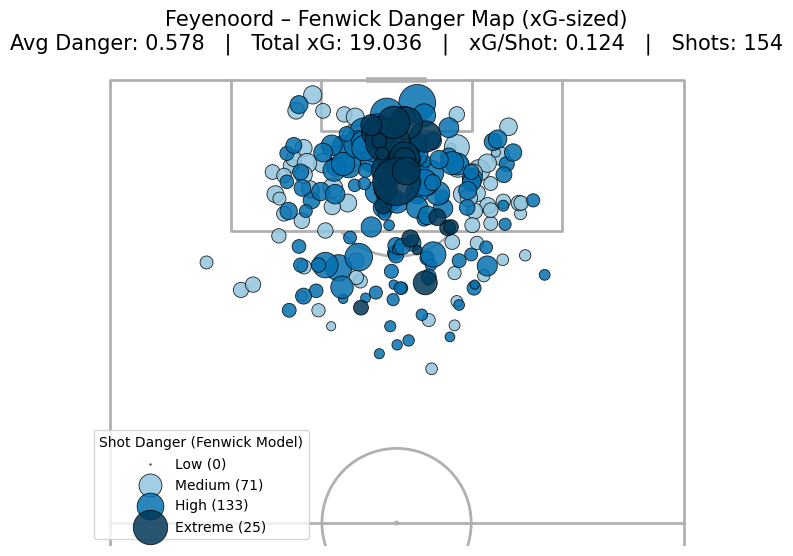

Saved: /Users/user/Downloads/xDanger/ShotDanger_Corsi.png


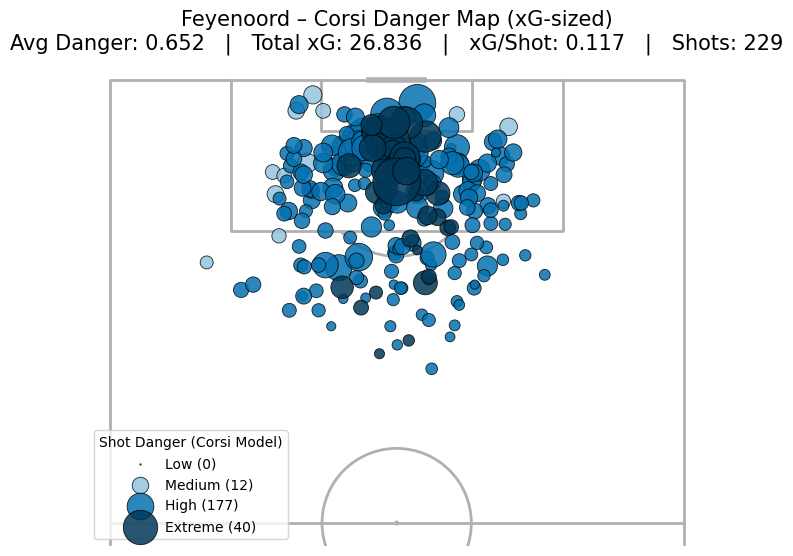

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
from mplsoccer.pitch import VerticalPitch
import numpy as np

# -----------------------------
# FILE PATHS (EDIT THESE)
# -----------------------------
xg_file = "/Users/user/XG/Eredivisie 2025-2026/all_matches_with_xg_qualifiers_enhanced.csv"
team_mapping_file = "/Users/user/XG/Eredivisie 2025-2026 Matches.csv" 
team_name = "Feyenoord"   # 👈 filter for this team


# =============================================================
# 1️⃣ LOAD SHOT DATA (with xG + danger scores)
# =============================================================
df = pd.read_csv(xg_file)

# Use your xG model
df["xG"] = df["xg_logit_2stage"]

# Check danger score columns
if "danger_score_fenwick" not in df.columns or "danger_score_corsi" not in df.columns:
    raise SystemExit("❌ Your CSV does not contain danger scores! Run the xG script first.")


# =============================================================
# 2️⃣ ADD TEAM MAPPING
# =============================================================
team_mapping_df = pd.read_csv(team_mapping_file)

team_map = (
    team_mapping_df[["matchInfo/contestant/1/id", "matchInfo/contestant/1/shortName"]]
    .drop_duplicates()
    .rename(columns={
        "matchInfo/contestant/1/id": "contestantId",
        "matchInfo/contestant/1/shortName": "Team"
    })
)

df["contestantId"] = df["contestantId"].astype(str)
team_map["contestantId"] = team_map["contestantId"].astype(str)

df = df.merge(team_map, on="contestantId", how="left")


# =============================================================
# 3️⃣ FILTER FOR SELECTED TEAM
# =============================================================
df_team = df[df["Team"] == team_name].copy()

if df_team.empty:
    raise SystemExit(f"❌ No shots found for team: {team_name}")

print(f"Loaded {len(df_team)} shots for {team_name}")


# =============================================================
# 4️⃣ SHOTTYPE + BLOCKED LOGIC (needed for Fenwick)
# =============================================================
df_team["typeId"] = df_team["typeId"].astype(int)
df_team["Blocked"] = df_team["qualifier_82"].notna()

def classify_shot(row):
    if row["typeId"] == 16: return "Goal"
    if row["typeId"] == 15: return "On Target"
    if row["typeId"] == 13: return "Missed"
    if row["typeId"] == 14: return "Post"
    return "Unknown"

df_team["ShotType"] = df_team.apply(classify_shot, axis=1)
df_team.loc[df_team["Blocked"], "ShotType"] = "Blocked"

# Fenwick = unblocked shots
df_team["Fenwick"] = (df_team["ShotType"] != "Blocked").astype(int)

# Corsi = all shots
df_team["Corsi"] = 1


# =============================================================
# 5️⃣ CREATE DANGER SCORE BINS
# =============================================================
danger_bins = [0, 0.25, 0.50, 0.75, 1.0]
danger_labels = ["Low", "Medium", "High", "Extreme"]

danger_colors = {
    "Low": "#d9f0ff",
    "Medium": "#92c5de",
    "High": "#0571b0",
    "Extreme": "#023858"
}

# Default danger score = fenwick
df_team["danger"] = df_team["danger_score_fenwick"]
df_team["danger_bin"] = pd.cut(
    df_team["danger"],
    bins=danger_bins,
    labels=danger_labels,
    include_lowest=True
)


# =============================================================
# 6️⃣ CALCULATE ALL XG METRICS FOR TITLES
# =============================================================
# Fenwick (unblocked shots)
df_fen = df_team[df_team["ShotType"] != "Blocked"]
fenwick_shots = len(df_fen)
total_xg_fenwick = df_fen["xG"].sum()
xg_per_shot_fenwick = total_xg_fenwick / max(fenwick_shots, 1)
avg_fenwick_danger = df_team["danger_score_fenwick"].mean()

# Corsi (all shots)
corsi_shots = len(df_team)
total_xg_corsi = df_team["xG"].sum()
xg_per_shot_corsi = total_xg_corsi / max(corsi_shots, 1)
avg_corsi_danger = df_team["danger_score_corsi"].mean()


# Print summary
print("\n==============================")
print(f"📊 {team_name} – Fenwick & Corsi xG Summary")
print("==============================")
print(f"Fenwick Shots: {fenwick_shots}")
print(f"Total Fenwick xG: {total_xg_fenwick:.3f}")
print(f"xG/Shot Fenwick: {xg_per_shot_fenwick:.3f}")
print("------------------------------")
print(f"Corsi Shots: {corsi_shots}")
print(f"Total Corsi xG: {total_xg_corsi:.3f}")
print(f"xG/Shot Corsi: {xg_per_shot_corsi:.3f}")
print("==============================\n")


# =============================================================
# 7️⃣ PLOT FENWICK DANGER MAP (with xG info in title)
# =============================================================
fig, ax = plt.subplots(figsize=(8, 12))
pitch = VerticalPitch(half=True, pitch_type='opta', pitch_color='white')
pitch.draw(ax=ax)

for level, color in danger_colors.items():
    subset = df_team[df_team["danger_bin"] == level]
    pitch.scatter(
        subset["x"], subset["y"],
        s=subset["xG"] * 1600,
        c=color,
        edgecolors="black",
        linewidth=0.6,
        alpha=0.85,
        ax=ax,
        label=f"{level} ({len(subset)})"
    )

ax.legend(title="Shot Danger (Fenwick Model)", loc='lower left')

ax.set_title(
    f"{team_name} – Fenwick Danger Map (xG-sized)\n"
    f"Avg Danger: {avg_fenwick_danger:.3f}   |   "
    f"Total xG: {total_xg_fenwick:.3f}   |   "
    f"xG/Shot: {xg_per_shot_fenwick:.3f}   |   "
    f"Shots: {fenwick_shots}",
    fontsize=15
)

fenwick_path = "/Users/user/Downloads/xDanger/ShotDanger_Fenwick.png"
plt.savefig(fenwick_path, dpi=300, bbox_inches='tight')
print("Saved:", fenwick_path)
plt.show()


# =============================================================
# 8️⃣ PLOT CORSI DANGER MAP (with xG info in title)
# =============================================================
fig, ax = plt.subplots(figsize=(8, 12))
pitch.draw(ax=ax)

df_team["danger"] = df_team["danger_score_corsi"]
df_team["danger_bin"] = pd.cut(
    df_team["danger"],
    bins=danger_bins,
    labels=danger_labels,
    include_lowest=True
)

for level, color in danger_colors.items():
    subset = df_team[df_team["danger_bin"] == level]
    pitch.scatter(
        subset["x"], subset["y"],
        s=subset["xG"] * 1600,
        c=color,
        edgecolors="black",
        linewidth=0.6,
        alpha=0.85,
        ax=ax,
        label=f"{level} ({len(subset)})"
    )

ax.legend(title="Shot Danger (Corsi Model)", loc='lower left')

ax.set_title(
    f"{team_name} – Corsi Danger Map (xG-sized)\n"
    f"Avg Danger: {avg_corsi_danger:.3f}   |   "
    f"Total xG: {total_xg_corsi:.3f}   |   "
    f"xG/Shot: {xg_per_shot_corsi:.3f}   |   "
    f"Shots: {corsi_shots}",
    fontsize=15
)

corsi_path = "/Users/user/Downloads/xDanger/ShotDanger_Corsi.png"
plt.savefig(corsi_path, dpi=300, bbox_inches='tight')
print("Saved:", corsi_path)
plt.show()


Saved: /Users/user/Downloads/Expected Shot Danger/Fenwick_Expected_Shot_Danger.png


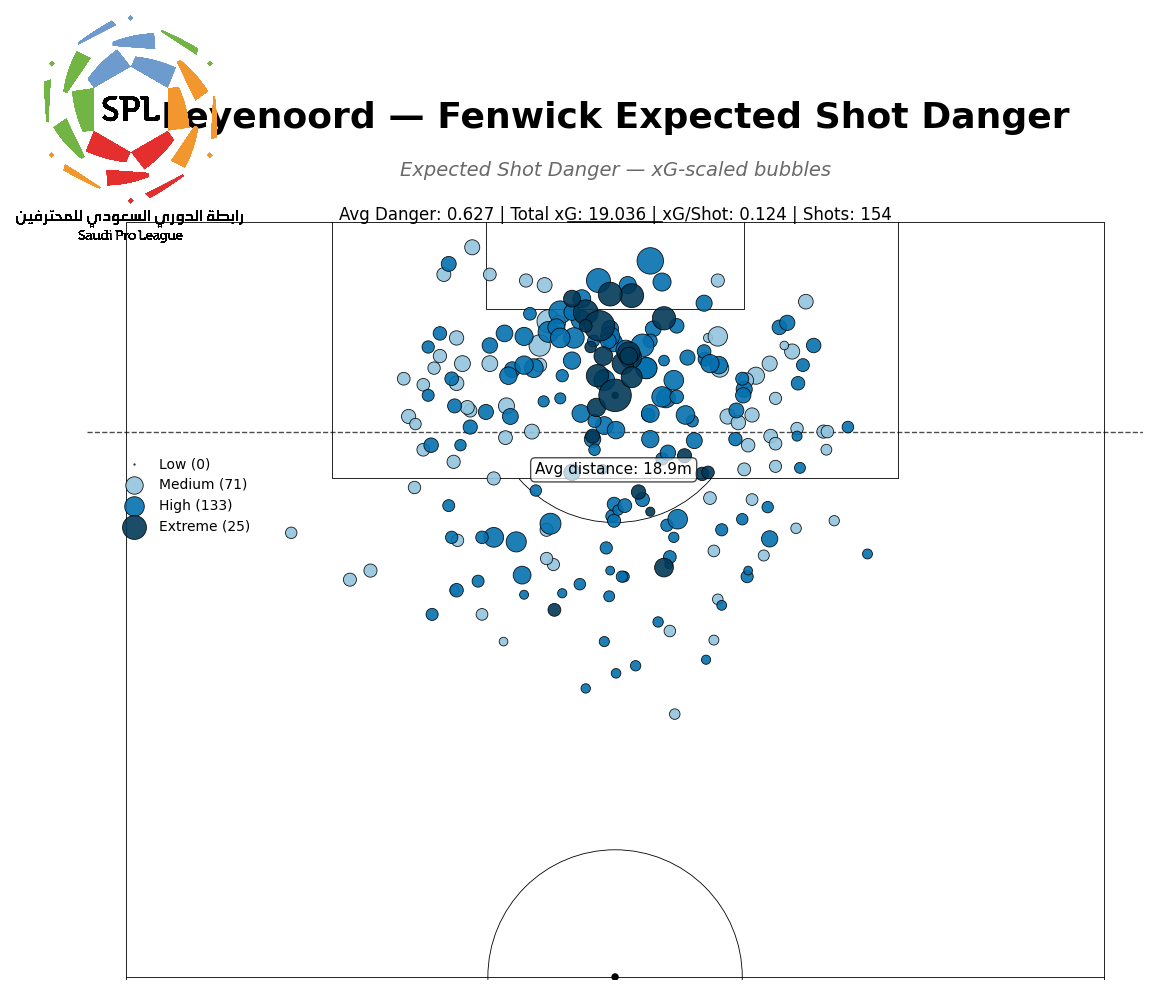

Saved: /Users/user/Downloads/Expected Shot Danger/Corsi_Expected_Shot_Danger.png


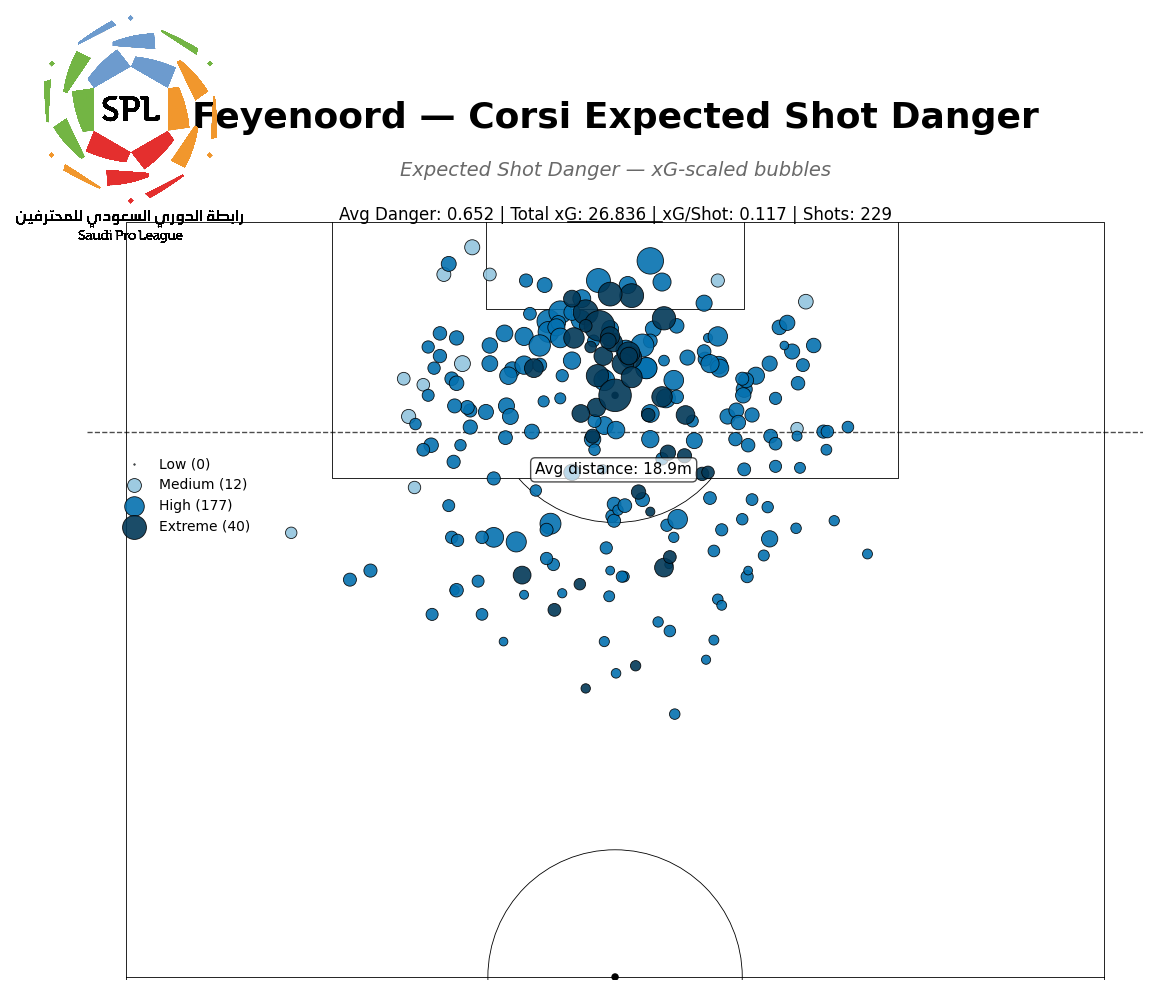

In [34]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from mplsoccer.pitch import VerticalPitch
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# ============================================================
# PATHS
# ============================================================
xg_file = "/Users/user/XG/Eredivisie 2025-2026/all_matches_with_xg_qualifiers_enhanced.csv"
team_mapping_file = "/Users/user/XG/Eredivisie 2025-2026 Matches.csv"
team_name = "Feyenoord"

output_folder = "/Users/user/Downloads/Expected Shot Danger/"
os.makedirs(output_folder, exist_ok=True)

logo_path = "/Users/user/Logo/SPL.png"   # optional logo

PITCH_LENGTH_M = 105  # for distance estimate

# ============================================================
# 1️⃣ LOAD SHOT DATA
# ============================================================
df = pd.read_csv(xg_file)
df["xG"] = df["xg_logit_2stage"]

if "danger_score_fenwick" not in df.columns or "danger_score_corsi" not in df.columns:
    raise SystemExit("❌ Missing danger score columns in CSV.")


# ============================================================
# 2️⃣ ADD TEAM MAPPING
# ============================================================
team_map_df = pd.read_csv(team_mapping_file)

team_map = (
    team_map_df[["matchInfo/contestant/1/id", "matchInfo/contestant/1/shortName"]]
    .drop_duplicates()
    .rename(columns={
        "matchInfo/contestant/1/id": "contestantId",
        "matchInfo/contestant/1/shortName": "Team"
    })
)

df["contestantId"] = df["contestantId"].astype(str)
team_map["contestantId"] = team_map["contestantId"].astype(str)

df = df.merge(team_map, on="contestantId", how="left")


# ============================================================
# 3️⃣ FILTER TEAM (ALL SHOTS)
# ============================================================
df_team = df[df["Team"] == team_name].copy()
if df_team.empty:
    raise SystemExit(f"❌ No shots found for {team_name}")

df_team["typeId"] = df_team["typeId"].astype(int)
df_team["Blocked"] = df_team["qualifier_82"].notna()


# ============================================================
# 4️⃣ SHOT TYPE / FENWICK / CORSI
# ============================================================
def classify_shot(row):
    if row["typeId"] == 16: return "Goal"
    if row["typeId"] == 15: return "On Target"
    if row["typeId"] == 13: return "Missed"
    if row["typeId"] == 14: return "Post"
    return "Unknown"

df_team["ShotType"] = df_team.apply(classify_shot, axis=1)
df_team.loc[df_team["Blocked"], "ShotType"] = "Blocked"

df_team["Fenwick"] = (df_team["ShotType"] != "Blocked").astype(int)
df_team["Corsi"] = 1

# ============================================================
# 5️⃣ DANGER BINS + COLOURS
# ============================================================
danger_bins = [0, 0.25, 0.50, 0.75, 1.0]
danger_labels = ["Low", "Medium", "High", "Extreme"]

danger_colors = {
    "Low": "#d9f0ff",
    "Medium": "#92c5de",
    "High": "#0571b0",
    "Extreme": "#023858"
}

# ============================================================
# 6️⃣ SUMMARY STATS (Fenwick & Corsi)
# ============================================================
# Fenwick
df_fen = df_team[df_team["ShotType"] != "Blocked"]
fen_shots = len(df_fen)
fen_total_xg = df_fen["xG"].sum()
fen_xg_per_shot = fen_total_xg / max(fen_shots, 1)
fen_avg_danger = df_fen["danger_score_fenwick"].mean()

# Corsi
corsi_shots = len(df_team)
corsi_total_xg = df_team["xG"].sum()
corsi_xg_per_shot = corsi_total_xg / max(corsi_shots, 1)
corsi_avg_danger = df_team["danger_score_corsi"].mean()

# distance (for annotation)
avg_x = df_team["x"].mean()
avg_distance = PITCH_LENGTH_M - avg_x if pd.notna(avg_x) else 0.0


# ============================================================
# 7️⃣ PLOTTER USING YOUR VISUAL STYLE (plt.scatter on VerticalPitch)
# ============================================================
def plot_expected_shot_danger(team_df, danger_column, title_main, stats_line, filename):
    # Work on a copy to avoid chained assignment warnings
    d = team_df.copy()

    d["danger"] = d[danger_column]
    d["danger_bin"] = pd.cut(
        d["danger"],
        bins=danger_bins,
        labels=danger_labels,
        include_lowest=True
    )

    # Pitch
    pitch = VerticalPitch(
        pitch_type='opta',
        pitch_color='white',
        line_color='black',
        half=False,
        linewidth=0.6
    )
    fig, ax = pitch.draw(figsize=(14, 10))
    fig.set_facecolor("white")

    # Focus on attacking half (like your Saudi visual)
    ax.set_ylim(49.8, 105)

    # SHOTS – NOTE: we use ax.scatter(y, x) like in your working example
    size_scale = 700
    for level, color in danger_colors.items():
        sub = d[d["danger_bin"] == level]
        ax.scatter(
            sub["y"],
            sub["x"],
            s=(sub["xG"] ** 0.8) * size_scale,
            color=color,
            edgecolors="black",
            linewidth=0.6,
            alpha=0.9,
            zorder=3,
            label=f"{level} ({len(sub)})"
        )

    # Average distance line
    avg_x_local = d["x"].mean()
    avg_y_local = d["y"].mean()

    ax.axhline(y=avg_x_local, color='black', linestyle='dashed',
               linewidth=1, alpha=0.7, zorder=1)

    ax.text(
        avg_y_local,
        avg_x_local - 2,
        f"Avg distance: {avg_distance:.1f}m",
        fontsize=11,
        color='black',
        ha='center',
        va='top',
        zorder=4,
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.7)
    )

    # Titles
    ax.text(
        50, 108, title_main,
        fontsize=26,
        weight='bold',
        color='black',
        ha='center',
        va='top'
    )
    ax.text(
        50, 104, "Expected Shot Danger — xG-scaled bubbles",
        fontsize=14,
        style='italic',
        color='dimgray',
        ha='center',
        va='top'
    )

    # Top stats line (Avg danger / Total xG / xG/Shot / Shots)
    ax.text(
        50, 101,
        stats_line,
        fontsize=12,
        color='black',
        ha='center',
        va='top'
    )

    # Logo (optional)
    try:
        logo_img = plt.imread(logo_path)
        imagebox = OffsetImage(logo_img, zoom=0.08)
        ab = AnnotationBbox(
            imagebox,
            (0.04, 1.02),
            frameon=False,
            xycoords='axes fraction',
            box_alignment=(0.5, 0.5)
        )
        ax.add_artist(ab)
    except FileNotFoundError:
        pass

    # Legend
    handles, labels = ax.get_legend_handles_labels()
    # Remove duplicates from repeated scatter calls
    by_label = dict(zip(labels, handles))
    ax.legend(
        by_label.values(),
        by_label.keys(),
        loc='lower left',
        bbox_to_anchor=(0.02, 0.52),
        frameon=False,
        fontsize=10
    )

    plt.subplots_adjust(right=0.9)

    out_path = os.path.join(output_folder, filename)
    plt.savefig(out_path, dpi=300, bbox_inches='tight', facecolor='white')
    print("Saved:", out_path)
    plt.show()


# ============================================================
# 8️⃣ GENERATE FENWICK + CORSI MAPS
# ============================================================
fen_title = f"{team_name} — Fenwick Expected Shot Danger"
fen_stats = (
    f"Avg Danger: {fen_avg_danger:.3f} | "
    f"Total xG: {fen_total_xg:.3f} | "
    f"xG/Shot: {fen_xg_per_shot:.3f} | "
    f"Shots: {fen_shots}"
)

plot_expected_shot_danger(
    df_team,
    "danger_score_fenwick",
    fen_title,
    fen_stats,
    "Fenwick_Expected_Shot_Danger.png"
)

corsi_title = f"{team_name} — Corsi Expected Shot Danger"
corsi_stats = (
    f"Avg Danger: {corsi_avg_danger:.3f} | "
    f"Total xG: {corsi_total_xg:.3f} | "
    f"xG/Shot: {corsi_xg_per_shot:.3f} | "
    f"Shots: {corsi_shots}"
)

plot_expected_shot_danger(
    df_team,
    "danger_score_corsi",
    corsi_title,
    corsi_stats,
    "Corsi_Expected_Shot_Danger.png"
)
